# Предсказание цены закрытия свечи - Биктоин - Временной интервал 1 час

In [78]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN,ConvLSTM2D, RNN, ConvLSTM1D, ConvLSTM3D
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import keras_tuner
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import cryptocompare

In [5]:
pip install cryptocompare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6290 sha256=ac405862cf9e63cbda092fed9ef3618c634bb91337fff2df01ee1cefc448fd51
  Stored in directory: /root/.cache/pip/wheels/97/81/6a/261bc499b9d9bf8b391eea52c90a4746b477539564b0a66c94
Successfully built cryptocompare


In [6]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.6 MB/s eta 0:00:00


In [79]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})

# Data Collection

In [23]:
df = []
d1 = datetime(2023,5,8,2)
for i in range(5):
    df_2000 = cryptocompare.get_historical_price_hour('BTC', 'USD', limit=2000, exchange='CCCAGG', toTs=d1)
    df_2000 = pd.DataFrame.from_dict(df_2000)
    df_2000['date'] = pd.to_datetime(df_2000['time'], unit='s')
    df_2000.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
    df.append(df_2000)
    d1 = d1 - timedelta(hours=2001)

df = list(reversed(df))
df = pd.concat(df)
df.index = df['date']
df.drop(columns=['date'], inplace=True)
cols = list(df.columns)
a, b = cols.index('high'), cols.index('close')
cols[b], cols[a] = cols[a], cols[b]
OHLCV = df[cols]
OHLCV

,close,low,open,volumefrom,volumeto,high
date,,,,,,
2022-03-17 02:00:00,41117.05,40969.20,41197.50,313.25,12884498.20,41354.94
2022-03-17 03:00:00,41027.09,41014.87,41117.05,209.47,8608513.06,41161.49
2022-03-17 04:00:00,41344.87,40941.20,41027.09,397.99,16377941.43,41350.82
2022-03-17 05:00:00,41084.37,41048.08,41344.87,432.72,17820744.72,41441.08
2022-03-17 06:00:00,40770.56,40696.44,41084.37,716.57,29301301.23,41106.89
...,...,...,...,...,...,...
2023-05-07 18:00:00,28963.05,28962.66,28999.80,435.38,12629027.65,29052.05
2023-05-07 19:00:00,29021.05,28885.90,28963.05,958.01,27722940.56,29035.55
2023-05-07 20:00:00,29031.83,29005.60,29021.05,368.94,10733964.74,29072.65


In [24]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10005 entries, 2022-03-17 02:00:00 to 2023-05-07 22:00:00
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close       10005 non-null  float64
 1   low         10005 non-null  float64
 2   open        10005 non-null  float64
 3   volumefrom  10005 non-null  float64
 4   volumeto    10005 non-null  float64
 5   high        10005 non-null  float64
dtypes: float64(6)
memory usage: 547.1 KB


In [25]:
OHLCV.describe()

,close,low,open,volumefrom,volumeto,high
count,10005.000000,10005.000000,10005.000000,10005.000000,1.000500e+04,10005.000000
mean,24856.323041,24759.851145,24857.561817,1975.301921,4.615444e+07,24952.533114
std,7646.206371,7617.328019,7647.849834,2103.621228,4.930916e+07,7675.860918
min,15631.360000,15480.690000,15631.360000,116.260000,2.648549e+06,15746.250000
25%,19520.100000,19454.760000,19520.100000,804.900000,1.965951e+07,19606.260000
50%,22448.140000,22377.760000,22448.140000,1395.000000,3.274892e+07,22554.870000
75%,28694.850000,28561.310000,28694.850000,2397.080000,5.619476e+07,28826.190000
max,47981.000000,47876.710000,47981.000000,80010.580000,2.314756e+09,48208.480000


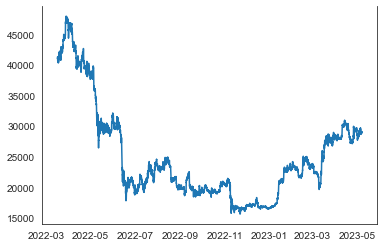

In [26]:
plt.plot(OHLCV['close'])

Bybit

In [80]:
import json 
import requests 
import pandas as pd
import datetime as dt
from time import sleep

In [109]:
symbol = 'BTCUSDT'

year = 2023
month = 7
day = 9

### Settings Block End   ###


def get_linenumber():
    cf = currentframe()
    global line_number
    line_number = cf.f_back.f_lineno


def get_bybit_bars(symbol, interval, startTime, endTime):

    url = 'https://api.bybit.com/public/linear/kline'
    startTime = str(int(startTime.timestamp()))
    endTime   = str(int(endTime.timestamp()))
    req_params = {'symbol' : symbol, 'interval' : interval, 'from' : startTime, 'to' : endTime}
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text)['result'])
    if (len(df.index) == 0):
        return None
    
    df.index = [dt.datetime.fromtimestamp(x) for x in df.open_time]
    return df


df_list = []
end_time = dt.datetime(year, month, day)
delta = dt.timedelta(hours=200)
start_time = end_time - delta

for i in range(51):
    new_df = get_bybit_bars(symbol, 60, start_time, end_time)
    df_list = [new_df] + df_list
    end_time = start_time
    start_time = end_time - delta 
    
df = pd.concat(df_list)
OHLCV = df[['open','high','low','close']]
print(OHLCV)

                        open     high      low    close
2022-05-10 00:00:00  30932.0  31900.0  30632.5  30949.5
2022-05-10 01:00:00  30949.5  31524.0  30775.0  30845.5
2022-05-10 02:00:00  30845.5  31336.0  30660.0  31091.5
2022-05-10 03:00:00  31091.5  31219.5  30018.0  30063.5
2022-05-10 04:00:00  30063.5  30982.0  29711.0  30779.5
...                      ...      ...      ...      ...
2023-07-08 19:00:00  30197.0  30210.0  30169.2  30194.9
2023-07-08 20:00:00  30194.9  30307.2  30193.6  30240.3
2023-07-08 21:00:00  30240.3  30262.1  30222.2  30240.0
2023-07-08 22:00:00  30240.0  30240.1  30170.5  30187.9
2023-07-08 23:00:00  30187.9  30187.9  30025.0  30096.3

[10200 rows x 4 columns]


In [110]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10200 entries, 2022-05-10 00:00:00 to 2023-07-08 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    10200 non-null  float64
 1   high    10200 non-null  float64
 2   low     10200 non-null  float64
 3   close   10200 non-null  float64
dtypes: float64(4)
memory usage: 398.4 KB


In [111]:
OHLCV.describe()

,open,high,low,close
count,10200.000000,10200.000000,10200.000000,10200.000000
mean,23177.509186,23271.135069,23082.521392,23177.427255
std,4474.211400,4495.331794,4453.815816,4474.077036
min,15632.500000,15763.000000,15440.000000,15632.500000
25%,19564.125000,19681.375000,19486.750000,19564.125000
50%,22656.750000,22768.750000,22544.250000,22656.750000
75%,27327.175000,27425.375000,27227.650000,27327.175000
max,32154.000000,32665.500000,31877.000000,32154.000000


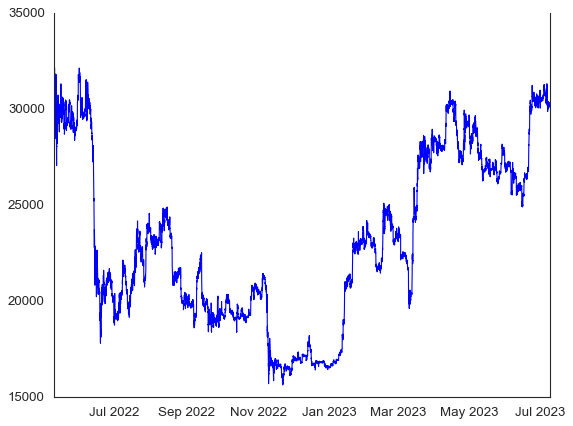

In [112]:
plt.plot(OHLCV['close'])

# Data prepocessing

Преобразуем наш датасет. Попробуем предоставить модели полную картину, происходящую на графике биржи, которые видят трейдеры, прогнозирующие цену с помощью технического анализа. Наш датасет будет состоять из следующих данных:

close - цена закрытия свечи;

low - цена низшей точки свечи;

high - цена высшей точки свечи;

open - цена открытия свечи;

close_diff - разница между ценами закрытия соседних свечей;

low_diff - разница между ценами низших точек соседних свечей;

high_diff - разница между ценами высших точек соседних свечей;

open_diff - разница между ценами открытия соседних свечей;

color_of_candle - цвет свечи(красный или зеленый, красный цвет - цена закрытия свечи ниже цены открытия, зеленый цвет - цена закрытия свечи выше цены открытия)

number_candle_trend - порядковый номер свечи в тренде(обозначает порядковый номер свечи в последовательности свечей одинакового цвета)

SMA_200 - 200-часовая скользящая средняя

EMA_200 - 200-часовая скользящая экспоненциальная

SMA_50 - 50-часовая скользящая средняя

EMA_50 - 50-часовая скользящая экспоненциальная

RSI - индекс относительной силы

MACD - линия MACD, является результатом взятия более долгосрочной EMA и вычитания ее из более краткосрочной EMA.Наиболее часто используемые значения - 26 часов для долгосрочной EMA и 12 часов для краткосрочной EMA

Signal - Сигнальная линия представляет собой EMA линии MACD, описанной в MACD. Трейдер может выбрать, какую EMA длины периода использовать для сигнальной линии, однако 9 является наиболее распространенной.

Histogram - С течением времени разница между линией MACD и сигнальной линией будет постоянно меняться. Гистограмма MACD учитывает это различие и отображает его в виде легко читаемой гистограммы. Разница между двумя линиями колеблется вокруг нулевой линии.

width_open_close - разница между ценой открытия и закрытия свечи

width_open_high - разница между ценой открытия и высшей ценой свечи

width_open_low - разница между ценой открытия и низшей ценой свечи

In [113]:
columns = {}
columns['close'] = list(OHLCV['close'].values)

SMA и EMA

In [114]:
SMA_200 = OHLCV['close'].rolling(window = 200).mean()
EMA_200 = OHLCV['close'].ewm(span=200).mean()
SMA_50 = OHLCV['close'].rolling(window = 50).mean()
EMA_50 = OHLCV['close'].ewm(span=50).mean()

SMA_200 = SMA_200.dropna()
EMA_200 = EMA_200.dropna()
SMA_50 = SMA_50.dropna()
EMA_50 = EMA_50.dropna()

columns['SMA_200'] = list(SMA_200.values)
columns['EMA_200'] = list(EMA_200.values)
columns['SMA_50'] = list(SMA_50.values)
columns['EMA_50'] = list(EMA_50.values)

RSI

In [115]:
def calculate_rsi(data, window=14):
    close = data['close']
    delta = close.diff()
    delta = delta[1:]

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = np.abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

rsi = calculate_rsi(OHLCV)
rsi = rsi.dropna()
rsi

2022-05-10 14:00:00    53.500482
2022-05-10 15:00:00    57.182628
2022-05-10 16:00:00    59.358760
2022-05-10 17:00:00    67.437206
2022-05-10 18:00:00    52.985224
                         ...    
2023-07-08 19:00:00    39.361702
2023-07-08 20:00:00    38.682766
2023-07-08 21:00:00    46.986667
2023-07-08 22:00:00    44.926058
2023-07-08 23:00:00    36.314700
Name: close, Length: 10186, dtype: float64

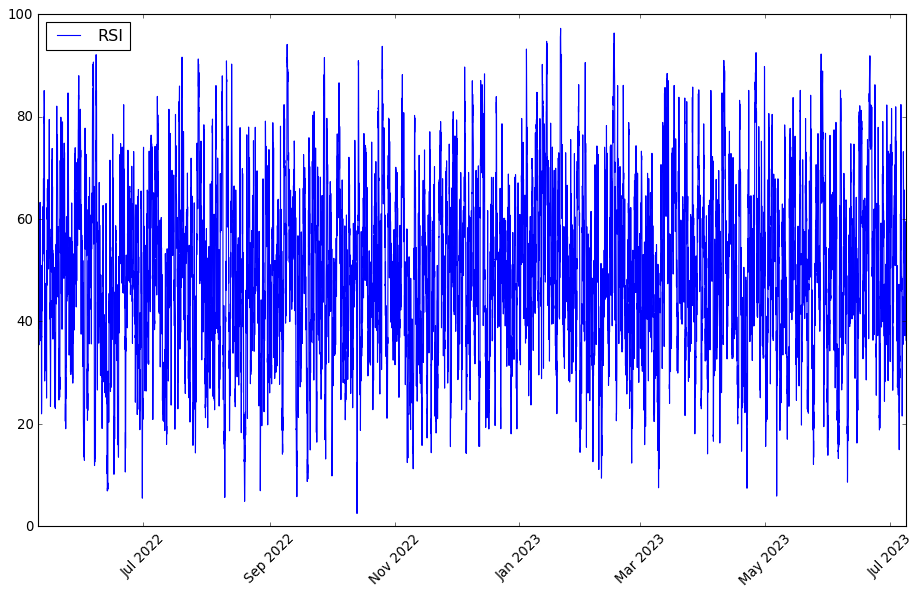

In [116]:
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(rsi, label='RSI', color = 'blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
columns['RSI'] = list(rsi.values)

MACD

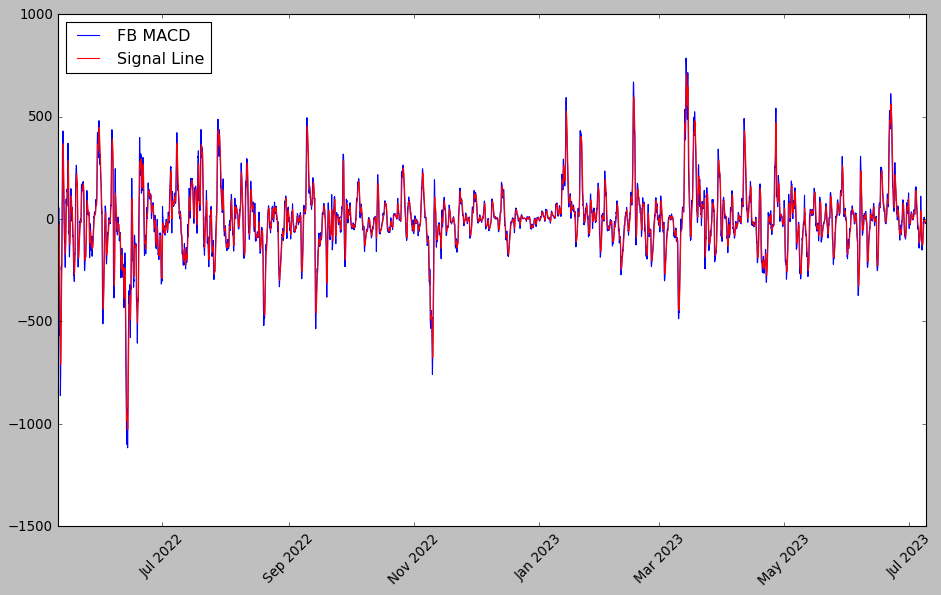

In [117]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    close = data['close']
    exp1 = close.ewm(span=fast, min_periods=fast).mean()
    exp2 = close.ewm(span=slow, min_periods=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

macd, signal_line, histogram = calculate_macd(OHLCV)

plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(OHLCV.index, macd, label='FB MACD', color = 'blue')
plt.plot(OHLCV.index, signal_line, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [118]:
macd = macd.dropna()
signal_line = signal_line.dropna()
histogram = histogram.dropna()

columns['macd'] = list(macd.values)
columns['signal_line'] = list(signal_line.values)
columns['histogram'] = list(histogram.values)

close_diff low_diff open_diff high_diff

In [119]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return diff
# df1 = df[1:]
def difference_for_every_column(df, df1): 
    for column in df.columns.values:
        diff = difference(df[column])
        df1[column+'_diff'] = diff
    return df1

In [120]:
diff_df = pd.DataFrame()
diff_df = difference_for_every_column(OHLCV[['close', 'low', 'open', 'high']] , diff_df) 
diff_df  

,close_diff,low_diff,open_diff,high_diff
0,-104.0,142.5,17.5,-376.0
1,246.0,-115.0,-104.0,-188.0
2,-1028.0,-642.0,246.0,-116.5
3,716.0,-307.0,-1028.0,-237.5
4,95.0,928.5,716.0,517.0
...,...,...,...,...
10194,-2.1,-11.0,-1.0,-4.6
10195,45.4,24.4,-2.1,97.2
10196,-0.3,28.6,45.4,-45.1
10197,-52.1,-51.7,-0.3,-22.0


In [121]:
columns['close_diff'] = list(diff_df['close_diff'].values)
columns['low_diff'] = list(diff_df['low_diff'].values)
columns['open_diff'] = list(diff_df['open_diff'].values)
columns['high_diff'] = list(diff_df['high_diff'].values)

width_open_close, width_open_high, width_open_low

In [122]:
close_values = OHLCV['close'].values
low_values = OHLCV['low'].values
open_values = OHLCV['open'].values
high_values = OHLCV['high'].values
width_open_close = np.zeros(shape= len(OHLCV))
width_open_high = np.zeros(shape=len(OHLCV))
width_open_low = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    width_open_close[i] = close_values[i] - open_values[i] 
    width_open_high[i] = high_values[i] - open_values[i]
    width_open_low[i] = open_values[i] - low_values[i]

columns['width_open_close'] = list(width_open_close)
columns['width_open_high'] = list(width_open_high)
columns['width_open_low'] = list(width_open_low)

color_of_candle, number_candle_trend

In [123]:
color_of_candle = []
number_candle_trend = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    if width_open_close[i] > 0:
        color_of_candle.append('green')
    else:
        color_of_candle.append('red')
        
number_candle_trend[0] = 1
cnt = 1
for i in range(1,len(OHLCV)):
    if (color_of_candle[i] == color_of_candle[i - 1]):
        cnt = cnt + 1
        number_candle_trend[i] = cnt
    else:
        cnt = 1
        number_candle_trend[i] = cnt

columns['color_of_candle'] = color_of_candle
columns['number_candle_trend'] = number_candle_trend

Соберем все признаки в один датасет

In [124]:
for key, value in columns.items():
    print(key, " -> ", len(value))

close  ->  10200
SMA_200  ->  10001
EMA_200  ->  10200
SMA_50  ->  10151
EMA_50  ->  10200
RSI  ->  10186
macd  ->  10175
signal_line  ->  10167
histogram  ->  10167
close_diff  ->  10199
low_diff  ->  10199
open_diff  ->  10199
high_diff  ->  10199
width_open_close  ->  10200
width_open_high  ->  10200
width_open_low  ->  10200
color_of_candle  ->  10200
number_candle_trend  ->  10200


In [125]:
df_candles = pd.DataFrame({})
for key, value in columns.items():
    df_candles[key] = value[-(len(SMA_200)):]
    
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend
0,29821.0,30058.8825,30021.517192,30087.190,30148.504367,37.584506,-5.972871,29.819856,-35.792727,-387.0,-357.0,93.0,-4.0,-387.0,0.5,491.0,red,1.0
1,29810.0,30053.1850,30019.086920,30073.590,30135.225411,44.581708,-35.933146,16.669255,-52.602401,-11.0,23.0,-387.0,-286.5,-11.0,101.0,81.0,red,2.0
2,30018.0,30049.0475,30019.074451,30067.690,30130.626914,47.494867,-42.404211,4.854562,-47.258773,208.0,28.5,-11.0,118.0,208.0,230.0,41.5,green,1.0
3,29722.5,30042.2025,30015.677303,30055.690,30114.617178,42.643805,-70.563541,-10.229059,-60.334482,-295.5,-48.5,208.0,30.0,-295.5,52.0,298.0,red,1.0
4,29895.5,30041.3625,30014.302785,30047.990,30106.021893,47.053619,-78.020983,-23.787444,-54.233540,173.0,-62.0,-295.5,-164.0,173.0,183.5,64.5,green,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,30194.9,30547.1185,30402.406215,30210.386,30279.503492,39.361702,-18.748039,-15.016697,-3.731342,-2.1,-11.0,-1.0,-4.6,-2.1,13.0,27.8,red,2.0
9997,30240.3,30544.1305,30400.793218,30211.160,30277.966100,38.682766,-14.873006,-14.987959,0.114953,45.4,24.4,-2.1,97.2,45.4,112.3,1.3,green,1.0
9998,30240.0,30541.5605,30399.193286,30208.060,30276.477234,46.986667,-11.691450,-14.328657,2.637207,-0.3,28.6,45.4,-45.1,-0.3,21.8,18.1,red,1.0
9999,30187.9,30538.5590,30397.090865,30205.818,30273.003617,44.926058,-13.221668,-14.107259,0.885591,-52.1,-51.7,-0.3,-22.0,-52.1,0.1,69.5,red,2.0


In [126]:
percent = []
for index, row in df_candles.iterrows():
    percent.append(abs(row['close_diff'])/row['close'])

change_percent_mean = np.array(percent).mean()

In [127]:
#делаем сдвиг по целевой переменной, чтобы для каждой строки целевой переменной стало значения закрытия цены на следующей свече
df_close_next = df_candles['close'][1:].values
df_candles = df_candles[:-1]
df_candles['close_next'] = df_close_next
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,29821.0,30058.8825,30021.517192,30087.190,30148.504367,37.584506,-5.972871,29.819856,-35.792727,-387.0,-357.0,93.0,-4.0,-387.0,0.5,491.0,red,1.0,29810.0
1,29810.0,30053.1850,30019.086920,30073.590,30135.225411,44.581708,-35.933146,16.669255,-52.602401,-11.0,23.0,-387.0,-286.5,-11.0,101.0,81.0,red,2.0,30018.0
2,30018.0,30049.0475,30019.074451,30067.690,30130.626914,47.494867,-42.404211,4.854562,-47.258773,208.0,28.5,-11.0,118.0,208.0,230.0,41.5,green,1.0,29722.5
3,29722.5,30042.2025,30015.677303,30055.690,30114.617178,42.643805,-70.563541,-10.229059,-60.334482,-295.5,-48.5,208.0,30.0,-295.5,52.0,298.0,red,1.0,29895.5
4,29895.5,30041.3625,30014.302785,30047.990,30106.021893,47.053619,-78.020983,-23.787444,-54.233540,173.0,-62.0,-295.5,-164.0,173.0,183.5,64.5,green,1.0,29858.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,30197.0,30549.8580,30404.491705,30213.562,30282.956696,42.417948,-18.798746,-14.083861,-4.714885,-1.0,19.6,37.3,-15.2,-1.0,16.6,17.8,red,1.0,30194.9
9996,30194.9,30547.1185,30402.406215,30210.386,30279.503492,39.361702,-18.748039,-15.016697,-3.731342,-2.1,-11.0,-1.0,-4.6,-2.1,13.0,27.8,red,2.0,30240.3
9997,30240.3,30544.1305,30400.793218,30211.160,30277.966100,38.682766,-14.873006,-14.987959,0.114953,45.4,24.4,-2.1,97.2,45.4,112.3,1.3,green,1.0,30240.0
9998,30240.0,30541.5605,30399.193286,30208.060,30276.477234,46.986667,-11.691450,-14.328657,2.637207,-0.3,28.6,45.4,-45.1,-0.3,21.8,18.1,red,1.0,30187.9


Кодируем категориальные переменнные

In [128]:
df_candles_supervised = df_candles.copy()

number_candle_trend_encoder = LabelEncoder()
df_candles_supervised["color_of_candle"] = number_candle_trend_encoder.fit_transform(df_candles_supervised["color_of_candle"])
color_of_candle_encoder = LabelEncoder()
df_candles_supervised["number_candle_trend"] = color_of_candle_encoder.fit_transform(df_candles_supervised["number_candle_trend"])


df_candles_supervised

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,29821.0,30058.8825,30021.517192,30087.190,30148.504367,37.584506,-5.972871,29.819856,-35.792727,-387.0,-357.0,93.0,-4.0,-387.0,0.5,491.0,1,0,29810.0
1,29810.0,30053.1850,30019.086920,30073.590,30135.225411,44.581708,-35.933146,16.669255,-52.602401,-11.0,23.0,-387.0,-286.5,-11.0,101.0,81.0,1,1,30018.0
2,30018.0,30049.0475,30019.074451,30067.690,30130.626914,47.494867,-42.404211,4.854562,-47.258773,208.0,28.5,-11.0,118.0,208.0,230.0,41.5,0,0,29722.5
3,29722.5,30042.2025,30015.677303,30055.690,30114.617178,42.643805,-70.563541,-10.229059,-60.334482,-295.5,-48.5,208.0,30.0,-295.5,52.0,298.0,1,0,29895.5
4,29895.5,30041.3625,30014.302785,30047.990,30106.021893,47.053619,-78.020983,-23.787444,-54.233540,173.0,-62.0,-295.5,-164.0,173.0,183.5,64.5,0,0,29858.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,30197.0,30549.8580,30404.491705,30213.562,30282.956696,42.417948,-18.798746,-14.083861,-4.714885,-1.0,19.6,37.3,-15.2,-1.0,16.6,17.8,1,0,30194.9
9996,30194.9,30547.1185,30402.406215,30210.386,30279.503492,39.361702,-18.748039,-15.016697,-3.731342,-2.1,-11.0,-1.0,-4.6,-2.1,13.0,27.8,1,1,30240.3
9997,30240.3,30544.1305,30400.793218,30211.160,30277.966100,38.682766,-14.873006,-14.987959,0.114953,45.4,24.4,-2.1,97.2,45.4,112.3,1.3,0,0,30240.0
9998,30240.0,30541.5605,30399.193286,30208.060,30276.477234,46.986667,-11.691450,-14.328657,2.637207,-0.3,28.6,45.4,-45.1,-0.3,21.8,18.1,1,0,30187.9


Преобразованный датасет имеет 39820 строк и 19 колонок

# Feature Selection

Определим наилучший метод для отбора признаков

Функция разбиения датасета и нормализации

In [129]:
def split_normalization_for_VIF_RFE_PCA(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.drop(['color_of_candle', 'number_candle_trend'], axis =1).columns.values
    # train

    train_norm = train.loc[:, features].values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)

    train_categorial = train.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    train_std = pd.concat([train_norm, train_categorial], axis=1)
    
    # test

    test_norm = test.loc[:, features].values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    

    test_categorial = test.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    test_std = pd.concat([test_norm, test_categorial], axis=1)
    
    # val
    val_norm = val.loc[:, features].values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)

    val_categorial = val.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    val_std = pd.concat([val_norm, val_categorial], axis=1)



    train_X = train_std.drop(['close_next', 'index'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_std['close_next']
    
    test_X = test_std.drop(['close_next', 'index'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_std['close_next']


    val_X = val_std.drop(['close_next', 'index'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_std['close_next']

    return train_X, train_y, test_X, test_y, val_X, val_y

Функция создания последовательностей

In [130]:
# multivariate output data prep
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(df, n_steps):

    columns = df.columns.values

    arrays = []
    for column in columns:
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

Метрики

In [131]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def count_money(real, forecast):
    profit = 0
    for i in range(1, len(real)):
        if ((forecast[i] > real[i-1]) & (real[i] > real[i-1])) | ((forecast[i] < real[i-1]) & (real[i] < real[i-1])):
            profit = profit + abs(real[i] - real[i-1])
        else:
            profit = profit - abs(real[i] - real[i-1])
    return profit

def count_money_2(real, forecast):
    profit = 0
    for i in range(1, len(real)):
        if ((forecast[i] > real[i-1]) & (real[i] > real[i-1])):
            if (forecast[i] > real[i]):
                profit = profit + abs(real[i] - real[i-1])
            else:
                profit = profit + abs(forecast[i] - real[i-1])
        elif ((forecast[i] < real[i-1]) & (real[i] < real[i-1])):
            if (forecast[i] < real[i]):
                profit = profit + abs(real[i] - real[i-1])
            else:
                profit = profit + abs(forecast[i] - real[i-1])
        else:
            profit = profit - abs(real[i] - real[i-1])
    return profit

def direction(real, forecast):
    directions = []
    for i in range(1, len(real)):
        if ((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1])):
                directions.append(1)
        else:
            directions.append(0)
    return sum(directions)/len(directions)


def success_prediction(real, forecast, diff = change_percent_mean, type_of_diff = 'percent'):
    success_prediction = []
    if (type_of_diff == 'absolute'):
        for i in range(1, len(real)):
            if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
               & (abs(forecast[i] - real[i]) < diff)):
                    success_prediction.append(1)
            else:
                success_prediction.append(0)
    else: 
        diff = round(diff, 2)
        for i in range(1, len(real)):
            if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
               & (abs(forecast[i] - real[i]) / real[i] < diff)):
                    success_prediction.append(1)
            else:
                success_prediction.append(0)
    return sum(success_prediction)/len(success_prediction)

def success_prediction_with_change_price(real, forecast, change_price = 5, diff = 250, type_of_diff = 'percent'):
    change_price = round(change_price/100, 2)
    success_prediction_with_change_price = []
    if (type_of_diff == 'absolute'):
        for i in range(1, len(real)):
            if (abs(real[i] - real[i-1]) / real[i-1] < change_price):
                if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
                   & (abs(forecast[i] - real[i]) < diff)):
                        success_prediction_with_change_price.append(1)
                else:
                    success_prediction_with_change_price.append(0)
    else: 
        diff = round(diff/100, 2)
        for i in range(1, len(real)):
            if (abs(real[i] - real[i-1]) / real[i-1] < change_price):
                if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
                   & (abs(forecast[i] - real[i]) / real[i] < diff)):
                        success_prediction_with_change_price.append(1)
                else:
                    success_prediction_with_change_price.append(0)
    return sum(success_prediction_with_change_price)/len(success_prediction_with_change_price)




def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    print('Среднее угадывание направления: ', direction(real, forecast))
    # print('Процент удачных предсказаний: ', success_prediction(real, forecast))
    # print('Процент удачных предсказаний c разницей между соседними ценами в 2: ', success_prediction_with_change_price(real, forecast))
    print('R2:', round(r2_score(real, forecast),20))
    print('SMAPE:', round(np.sqrt(smape(real, forecast)),20))
    print('Прибыль, при условии закрытия сделки по каждой свечи:', round(count_money(real, forecast), 20))
    print('Прибыль, при условии закрытия сделки по каждой свечи (способ 2):', round(count_money_2(real, forecast), 20))
    
    plt.plot(real-forecast)
    

    
    
def metrics_short(real, forecast):
    real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    print('R2:', round(r2_score(real, forecast),20))
    print('SMAPE:', round(np.sqrt(smape(real, forecast)),20))

VIF

In [132]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_creation(X):
    vif_df = pd.DataFrame()
    vif_df['Feature Name'] = X.columns
    vif_df['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

vif_df = df_candles_supervised.drop(['close_next'], axis =1)
vif_df = vif_creation(vif_df)
vif_df

,Feature Name,Vif Factor
0,close,1.072218e+05
1,SMA_200,1.439041e+04
2,EMA_200,1.929570e+04
3,SMA_50,1.803525e+05
4,EMA_50,2.674185e+05
5,RSI,1.737077e+01
6,macd,inf
7,signal_line,inf
8,histogram,inf
9,close_diff,inf


Выберем признаки со значением меньше 6

In [133]:
columns_vif = ['close']
for index, row in vif_df.iterrows():
    if (row['Vif Factor'] < 20):
      columns_vif.append(row['Feature Name'])

columns_vif.append('close_next')


df_candles_VIF = df_candles_supervised[columns_vif]

df_candles_VIF


,close,RSI,low_diff,open_diff,high_diff,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,29821.0,37.584506,-357.0,93.0,-4.0,0.5,491.0,1,0,29810.0
1,29810.0,44.581708,23.0,-387.0,-286.5,101.0,81.0,1,1,30018.0
2,30018.0,47.494867,28.5,-11.0,118.0,230.0,41.5,0,0,29722.5
3,29722.5,42.643805,-48.5,208.0,30.0,52.0,298.0,1,0,29895.5
4,29895.5,47.053619,-62.0,-295.5,-164.0,183.5,64.5,0,0,29858.5
...,...,...,...,...,...,...,...,...,...,...
9995,30197.0,42.417948,19.6,37.3,-15.2,16.6,17.8,1,0,30194.9
9996,30194.9,39.361702,-11.0,-1.0,-4.6,13.0,27.8,1,1,30240.3
9997,30240.3,38.682766,24.4,-2.1,97.2,112.3,1.3,0,0,30240.0
9998,30240.0,46.986667,28.6,45.4,-45.1,21.8,18.1,1,0,30187.9


Epoch 1/20
400/400 [==============================] - 39s 73ms/step - loss: 0.0335 - mean_absolute_error: 0.1148 - val_loss: 0.0313 - val_mean_absolute_error: 0.1333
Epoch 2/20
400/400 [==============================] - 27s 67ms/step - loss: 0.0126 - mean_absolute_error: 0.0758 - val_loss: 0.0055 - val_mean_absolute_error: 0.0548
Epoch 3/20
400/400 [==============================] - 27s 67ms/step - loss: 0.0085 - mean_absolute_error: 0.0642 - val_loss: 0.0111 - val_mean_absolute_error: 0.0891
Epoch 4/20
400/400 [==============================] - 26s 64ms/step - loss: 0.0065 - mean_absolute_error: 0.0558 - val_loss: 0.1489 - val_mean_absolute_error: 0.3350
Epoch 5/20
400/400 [==============================] - 26s 65ms/step - loss: 0.0056 - mean_absolute_error: 0.0524 - val_loss: 0.0045 - val_mean_absolute_error: 0.0461
Epoch 6/20
400/400 [==============================] - 25s 64ms/step - loss: 0.0051 - mean_absolute_error: 0.0493 - val_loss: 0.0033 - val_mean_absolute_error: 0.0409
Epoc

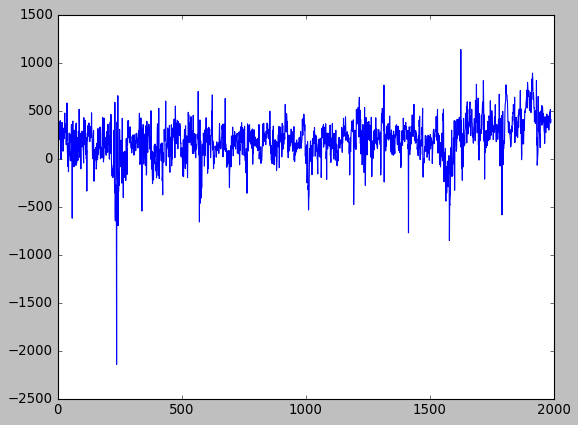

In [134]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_VIF)

n_steps = 10
Train_X_sq = split_sequences(train_X, n_steps)
Test_X_sq = split_sequences(test_X, n_steps)
Val_X_sq = split_sequences(val_X, n_steps)


train_y_sq = train_y[n_steps - 1: -1]
val_y_sq = val_y[n_steps - 1: -1]
test_y_sq = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_sq.shape[1], Train_X_sq.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(Train_X_sq, train_y_sq, batch_size=16, epochs=20, validation_data=(Val_X_sq, val_y_sq), callbacks = [callback])

yhat = model.predict(Test_X_sq)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_VIF = yhat.reshape(yhat.shape[0])
inv_y_VIF = test_y_sq.values
for i in range(len(inv_yhat_VIF)):
    inv_yhat_VIF[i] = inv_yhat_VIF[i] * scale + mean
    inv_y_VIF [i] = inv_y_VIF [i] * scale + mean

metrics(inv_y_VIF, inv_yhat_VIF)


RFE

In [135]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_RFE={}
Train_yhat_metrics_RFE['RMSE'] = []
Train_yhat_metrics_RFE['MAPE'] = []
Train_yhat_metrics_RFE['SMAPE'] = []
Train_yhat_metrics_RFE['R2'] = []
Train_yhat_metrics_RFE['direction'] = []
Train_yhat_metrics_RFE['profit'] = []

Test_yhat_metrics_RFE={}
Test_yhat_metrics_RFE['RMSE'] = []
Test_yhat_metrics_RFE['MAPE'] = []
Test_yhat_metrics_RFE['SMAPE'] = []
Test_yhat_metrics_RFE['R2'] = []
Test_yhat_metrics_RFE['direction'] = []
Test_yhat_metrics_RFE['profit'] = []
 
m=train_X.shape[1]-1

features_rfe = []

for i in range(m):

    train_y_1 = train_y.copy()
    
    rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-i)            
    rfe = rfe.fit(train_X, train_y_1)
    
    Train_X_std_rfe = train_X.loc[:,rfe.support_]
    Test_X_std_rfe = test_X.loc[:,rfe.support_]
    Val_X_std_rfe = val_X.loc[:,rfe.support_]
    
    features_rfe.append(rfe.support_)
    
    n_steps = 10
    Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
    Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
    Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


    train_y_rfe = train_y[n_steps - 1: -1]
    val_y_rfe = val_y[n_steps - 1: -1]
    test_y_rfe = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
    model.fit(Train_X_std_rfe, train_y_rfe, batch_size=16, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_rfe)
    yhat_test = model.predict(Test_X_std_rfe)
   
    mean = scaler.mean_
    mean = mean[len(mean) - 1]
    scale = scaler.scale_
    scale = scale[len(scale) - 1]
   
    inv_yhat_train_RFE = yhat_train.reshape(yhat_train.shape[0])
    inv_y_train_RFE = train_y_rfe.copy().values
    
    for i in range(len(inv_yhat_train_RFE)):
        inv_yhat_train_RFE[i] = inv_yhat_train_RFE[i] * scale + mean
        inv_y_train_RFE[i] = inv_y_train_RFE [i] * scale + mean
    
   
    inv_yhat_test_RFE = yhat_test.reshape(yhat_test.shape[0])
    inv_y_test_RFE = test_y_rfe.copy().values
    for i in range(len(inv_yhat_test_RFE)):
        inv_yhat_test_RFE[i] = inv_yhat_test_RFE[i] * scale + mean
        inv_y_test_RFE[i] = inv_y_test_RFE [i] * scale + mean

    Train_yhat_metrics_RFE['RMSE'].append(np.sqrt(mean_squared_error(inv_y_train_RFE, inv_yhat_train_RFE)))
    Train_yhat_metrics_RFE['MAPE'].append(round((abs(inv_y_train_RFE-inv_yhat_train_RFE)/inv_y_train_RFE).mean(),4))
    Train_yhat_metrics_RFE['SMAPE'].append(round(np.sqrt(smape(inv_y_train_RFE, inv_yhat_train_RFE)),20))
    Train_yhat_metrics_RFE['R2'].append(round(r2_score(inv_y_train_RFE, inv_yhat_train_RFE),20))
    Train_yhat_metrics_RFE['direction'].append(round(direction(inv_y_train_RFE, inv_yhat_train_RFE),4))
    Train_yhat_metrics_RFE['profit'].append(round(count_money(inv_y_train_RFE, inv_yhat_train_RFE), 20))

    Test_yhat_metrics_RFE['RMSE'].append(np.sqrt(mean_squared_error(inv_y_test_RFE, inv_yhat_test_RFE)))
    Test_yhat_metrics_RFE['MAPE'].append(round((abs(inv_y_test_RFE-inv_yhat_test_RFE)/inv_y_test_RFE).mean(),4))
    Test_yhat_metrics_RFE['SMAPE'].append(round(np.sqrt(smape(inv_y_test_RFE, inv_yhat_test_RFE)),20))
    Test_yhat_metrics_RFE['R2'].append(round(r2_score(inv_y_test_RFE, inv_yhat_test_RFE),20))
    Test_yhat_metrics_RFE['direction'].append(round(direction(inv_y_test_RFE, inv_yhat_test_RFE),4))
    Test_yhat_metrics_RFE['profit'].append(round(count_money(inv_y_test_RFE, inv_yhat_test_RFE), 20))

    
    


Epoch 1/20
400/400 [==============================] - 38s 73ms/step - loss: 0.0269 - mean_absolute_error: 0.1040 - val_loss: 0.0482 - val_mean_absolute_error: 0.1805
Epoch 2/20
400/400 [==============================] - 26s 66ms/step - loss: 0.0084 - mean_absolute_error: 0.0638 - val_loss: 0.0073 - val_mean_absolute_error: 0.0664
Epoch 3/20
400/400 [==============================] - 26s 66ms/step - loss: 0.0058 - mean_absolute_error: 0.0534 - val_loss: 0.0425 - val_mean_absolute_error: 0.1606
Epoch 4/20
400/400 [==============================] - 27s 68ms/step - loss: 0.0047 - mean_absolute_error: 0.0478 - val_loss: 0.0089 - val_mean_absolute_error: 0.0719
Epoch 5/20
63/63 [==============================] - 2s 33ms/step
Epoch 1/20
400/400 [==============================] - 35s 65ms/step - loss: 0.0299 - mean_absolute_error: 0.1059 - val_loss: 0.2669 - val_mean_absolute_error: 0.4422
Epoch 2/20
400/400 [==============================] - 25s 61ms/step - loss: 0.0093 - mean_absolute_error:

Epoch 4/20
400/400 [==============================] - 25s 64ms/step - loss: 0.0067 - mean_absolute_error: 0.0559 - val_loss: 0.0203 - val_mean_absolute_error: 0.1174
Epoch 5/20
63/63 [==============================] - 2s 32ms/step
Epoch 1/20
400/400 [==============================] - 33s 65ms/step - loss: 0.0318 - mean_absolute_error: 0.1100 - val_loss: 0.0226 - val_mean_absolute_error: 0.1144
Epoch 2/20
400/400 [==============================] - 25s 62ms/step - loss: 0.0109 - mean_absolute_error: 0.0715 - val_loss: 0.0054 - val_mean_absolute_error: 0.0520
Epoch 3/20
400/400 [==============================] - 25s 62ms/step - loss: 0.0076 - mean_absolute_error: 0.0595 - val_loss: 0.0525 - val_mean_absolute_error: 0.1913
Epoch 4/20
400/400 [==============================] - 24s 59ms/step - loss: 0.0063 - mean_absolute_error: 0.0541 - val_loss: 0.0720 - val_mean_absolute_error: 0.2249
Epoch 5/20
400/400 [==============================] - 25s 62ms/step - loss: 0.0052 - mean_absolute_error:

63/63 [==============================] - 2s 33ms/step
Epoch 1/20
400/400 [==============================] - 34s 69ms/step - loss: 0.0547 - mean_absolute_error: 0.1287 - val_loss: 0.0091 - val_mean_absolute_error: 0.0630
Epoch 2/20
400/400 [==============================] - 27s 67ms/step - loss: 0.0156 - mean_absolute_error: 0.0853 - val_loss: 0.0183 - val_mean_absolute_error: 0.1161
Epoch 3/20
400/400 [==============================] - 27s 68ms/step - loss: 0.0106 - mean_absolute_error: 0.0687 - val_loss: 0.0149 - val_mean_absolute_error: 0.0948
Epoch 4/20
63/63 [==============================] - 2s 34ms/step
Epoch 1/20
400/400 [==============================] - 38s 75ms/step - loss: 0.0347 - mean_absolute_error: 0.1178 - val_loss: 0.1094 - val_mean_absolute_error: 0.2909
Epoch 2/20
400/400 [==============================] - 27s 68ms/step - loss: 0.0143 - mean_absolute_error: 0.0808 - val_loss: 0.0417 - val_mean_absolute_error: 0.1696
Epoch 3/20
400/400 [==============================]

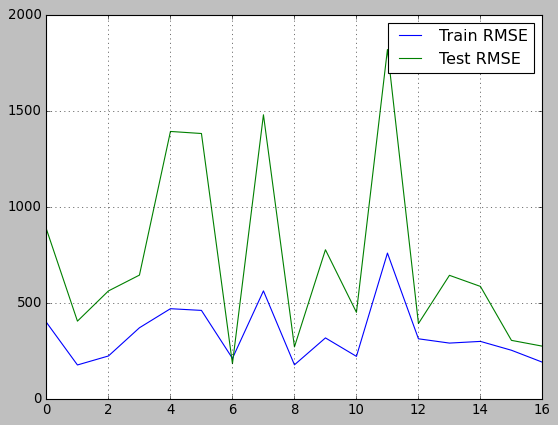

In [136]:
plt.plot(Train_yhat_metrics_RFE['RMSE'], label='Train RMSE')
plt.plot(Test_yhat_metrics_RFE['RMSE'], label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

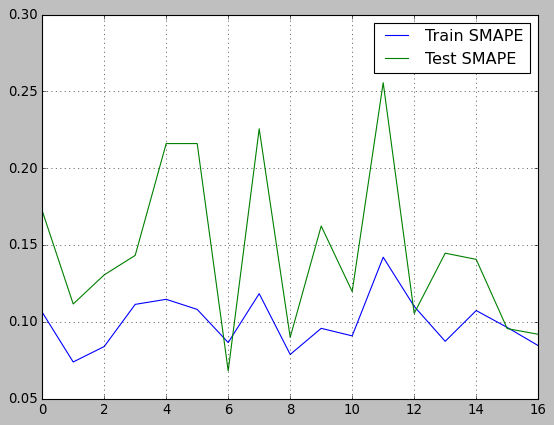

In [137]:
plt.plot(Train_yhat_metrics_RFE['SMAPE'], label='Train SMAPE')
plt.plot(Test_yhat_metrics_RFE['SMAPE'], label='Test SMAPE')
plt.legend()
plt.grid()
plt.show()

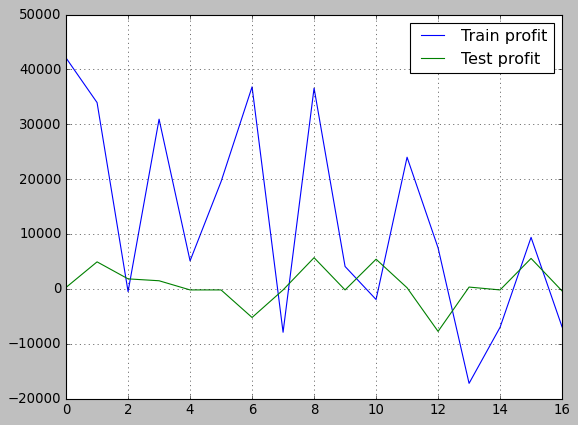

In [138]:
plt.plot(Train_yhat_metrics_RFE['profit'], label='Train profit')
plt.plot(Test_yhat_metrics_RFE['profit'], label='Test profit')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(Train_yhat_metrics_RFE['direction'], label='Train direction')
plt.plot(Test_yhat_metrics_RFE['direction'], label='Test direction')
plt.legend()
plt.grid()
plt.show()

Сравнив все показатели самым лучшим показателем будет число 6 для RFE

Epoch 1/20
400/400 [==============================] - 33s 66ms/step - loss: 0.0520 - mean_absolute_error: 0.1233 - val_loss: 0.0871 - val_mean_absolute_error: 0.2674
Epoch 2/20
400/400 [==============================] - 26s 65ms/step - loss: 0.0130 - mean_absolute_error: 0.0748 - val_loss: 0.0059 - val_mean_absolute_error: 0.0547
Epoch 3/20
400/400 [==============================] - 26s 65ms/step - loss: 0.0093 - mean_absolute_error: 0.0642 - val_loss: 0.0936 - val_mean_absolute_error: 0.2631
Epoch 4/20
400/400 [==============================] - 27s 69ms/step - loss: 0.0074 - mean_absolute_error: 0.0564 - val_loss: 0.0232 - val_mean_absolute_error: 0.1185
Epoch 5/20
63/63 [==============================] - 2s 27ms/step
Тест на стационарность:
	T-статистика = -1.912
	P-значение = 0.327
Критические значения :
	1%: -3.433675467561267 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.863008999826203 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.5675520348463654 -

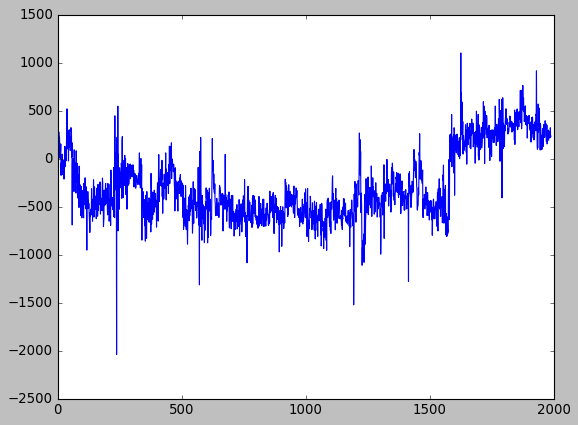

In [139]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)

rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-6)            
rfe = rfe.fit(train_X, train_y)

Train_X_std_rfe = train_X.loc[:,rfe.support_]
Test_X_std_rfe = test_X.loc[:,rfe.support_]
Val_X_std_rfe = val_X.loc[:,rfe.support_]

features_rfe.append(rfe.support_)

n_steps = 10
Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


train_y_rfe = train_y[n_steps - 1: -1]
val_y_rfe = val_y[n_steps - 1: -1]
test_y_rfe = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(Train_X_std_rfe, train_y_rfe, batch_size=16, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]

inv_yhat_train_RFE = yhat_train.reshape(yhat_train.shape[0])
inv_y_train_RFE = train_y_rfe.copy().values

for i in range(len(inv_yhat_train_RFE)):
    inv_yhat_train_RFE[i] = inv_yhat_train_RFE[i] * scale + mean
    inv_y_train_RFE[i] = inv_y_train_RFE [i] * scale + mean


inv_yhat_test_RFE = yhat_test.reshape(yhat_test.shape[0])
inv_y_test_RFE = test_y_rfe.copy().values
for i in range(len(inv_yhat_test_RFE)):
    inv_yhat_test_RFE[i] = inv_yhat_test_RFE[i] * scale + mean
    inv_y_test_RFE[i] = inv_y_test_RFE [i] * scale + mean
    
metrics(inv_y_test_RFE, inv_yhat_test_RFE)

PCA

In [ ]:
# split a multivariate sequence into samples
def split_sequences_PCA(df, n_steps):

    arrays = []
    for i in range(len(df.shape[0])):
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_PCA={}
Train_yhat_metrics_PCA['RMSE'] = []
Train_yhat_metrics_PCA['MAPE'] = []
Train_yhat_metrics_PCA['SMAPE'] = []
Train_yhat_metrics_PCA['R2'] = []
Train_yhat_metrics_PCA['direction'] = []
Train_yhat_metrics_PCA['profit'] = []

Test_yhat_metrics_PCA={}
Test_yhat_metrics_PCA['RMSE'] = []
Test_yhat_metrics_PCA['MAPE'] = []
Test_yhat_metrics_PCA['SMAPE'] = []
Test_yhat_metrics_PCA['R2'] = []
Test_yhat_metrics_PCA['direction'] = []
Test_yhat_metrics_PCA['profit'] = []
 
m=train_X.shape[1]-1

features_pca = []

for i in range(m):
    
    pca = PCA(n_components=train_X.shape[1]-i)           
    
    Train_X_std_pca = pca.fit_transform(train_X)
    Val_X_std_pca = pca.fit_transform(val_X)
    Test_X_std_pca = pca.fit_transform(test_X)
    
    
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    Val_X_std_pca = pd.DataFrame(Val_X_std_pca)


    n_steps = 10
    Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
    Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
    Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)

    train_y_pca = train_y[n_steps - 1: -1]
    val_y_pca = val_y[n_steps - 1: -1]
    test_y_pca = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
    model.fit(Train_X_std_pca, train_y_pca, batch_size=72, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_pca)
    yhat_test = model.predict(Test_X_std_pca)

    mean = scaler.mean_
    mean = mean[len(mean) - 1]
    scale = scaler.scale_
    scale = scale[len(scale) - 1]
    inv_yhat_train_PCA = yhat_train.reshape(yhat_train.shape[0])
    inv_y_train_PCA = train_y_rfe.copy().values
    for i in range(len(inv_yhat_train_PCA)):
        inv_yhat_train_PCA[i] = inv_yhat_train_PCA[i] * scale + mean
        inv_y_train_PCA[i] = inv_y_train_PCA[i] * scale + mean

    inv_yhat_test_PCA = yhat_test.reshape(yhat_test.shape[0])
    inv_y_test_PCA = test_y_pca.copy().values
    for i in range(len(inv_yhat_test_PCA)):
        inv_yhat_test_PCA[i] = inv_yhat_test_PCA[i] * scale + mean
        inv_y_test_PCA[i] = inv_y_test_PCA[i] * scale + mean

    Train_yhat_metrics_PCA['RMSE'].append(np.sqrt(mean_squared_error(inv_y_train_PCA, inv_yhat_train_PCA)))
    Train_yhat_metrics_PCA['MAPE'].append(round((abs(inv_y_train_PCA-inv_yhat_train_PCA)/inv_y_train_PCA).mean(),4))
    Train_yhat_metrics_PCA['SMAPE'].append(round(np.sqrt(smape(inv_y_train_PCA, inv_yhat_train_PCA)),20))
    Train_yhat_metrics_PCA['R2'].append(round(r2_score(inv_y_train_PCA, inv_yhat_train_PCA),20))
    Train_yhat_metrics_PCA['direction'].append(round(direction(inv_y_train_PCA, inv_yhat_train_PCA),4))
    Train_yhat_metrics_PCA['profit'].append(round(count_money(inv_y_train_PCA, inv_yhat_train_PCA), 20))

    Test_yhat_metrics_PCA['RMSE'].append(np.sqrt(mean_squared_error(inv_y_test_PCA, inv_yhat_test_PCA)))
    Test_yhat_metrics_PCA['MAPE'].append(round((abs(inv_y_test_PCA-inv_yhat_test_PCA)/inv_y_test_PCA).mean(),4))
    Test_yhat_metrics_PCA['SMAPE'].append(round(np.sqrt(smape(inv_y_test_PCA, inv_yhat_test_PCA)),20))
    Test_yhat_metrics_PCA['R2'].append(round(r2_score(inv_y_test_PCA, inv_yhat_test_PCA),20))
    Test_yhat_metrics_PCA['direction'].append(round(direction(inv_y_test_PCA, inv_yhat_test_PCA),4))
    Test_yhat_metrics_PCA['profit'].append(round(count_money(inv_y_test_PCA, inv_yhat_test_PCA), 20))

Epoch 1/20
710/710 [==============================] - 68s 89ms/step - loss: 0.0200 - mean_absolute_error: 0.0786 - val_loss: 20.9173 - val_mean_absolute_error: 3.8982
Epoch 2/20
710/710 [==============================] - 61s 86ms/step - loss: 0.0041 - mean_absolute_error: 0.0451 - val_loss: 14.0927 - val_mean_absolute_error: 2.9232
Epoch 3/20
710/710 [==============================] - 61s 86ms/step - loss: 0.0026 - mean_absolute_error: 0.0345 - val_loss: 14.1117 - val_mean_absolute_error: 2.9335
Epoch 4/20
710/710 [==============================] - 61s 86ms/step - loss: 0.0019 - mean_absolute_error: 0.0297 - val_loss: 12.4842 - val_mean_absolute_error: 2.8033
Epoch 5/20
710/710 [==============================] - 61s 86ms/step - loss: 0.0015 - mean_absolute_error: 0.0262 - val_loss: 10.1538 - val_mean_absolute_error: 2.4709
Epoch 6/20
710/710 [==============================] - 61s 86ms/step - loss: 0.0013 - mean_absolute_error: 0.0245 - val_loss: 13.4505 - val_mean_absolute_error: 2.920

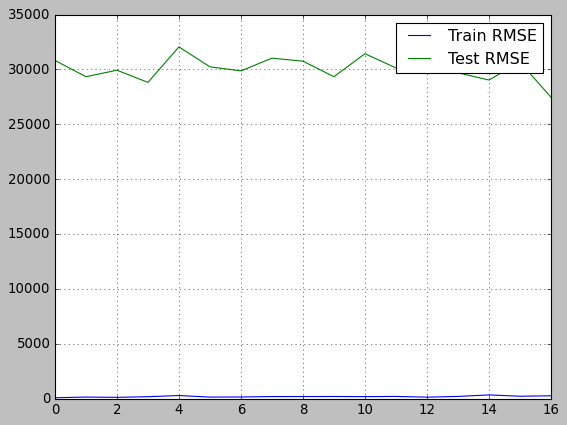

In [ ]:
plt.plot(Train_yhat_metrics_PCA['RMSE'], label='Train RMSE')
plt.plot(Test_yhat_metrics_PCA['RMSE'], label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

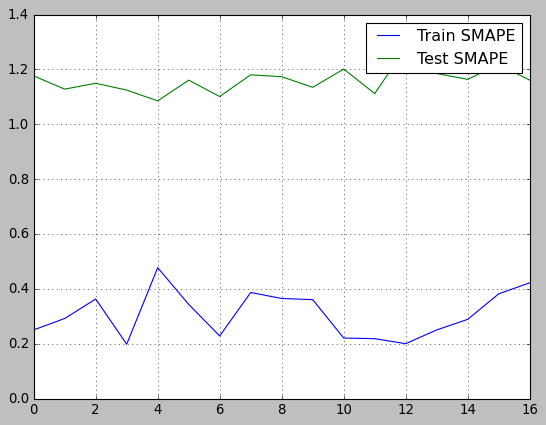

In [ ]:
plt.plot(Train_yhat_metrics_PCA['SMAPE'], label='Train SMAPE')
plt.plot(Test_yhat_metrics_PCA['SMAPE'], label='Test SMAPE')
plt.legend()
plt.grid()
plt.show()

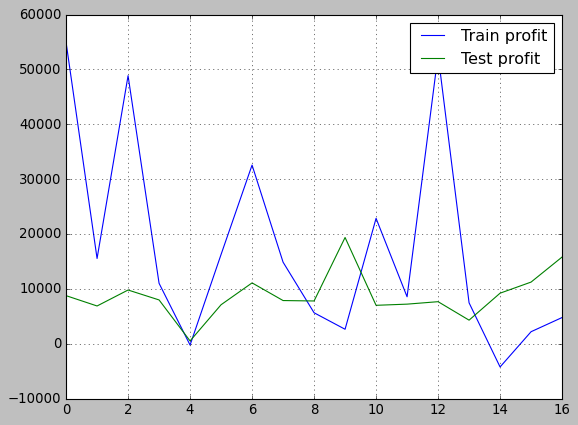

In [ ]:
plt.plot(Train_yhat_metrics_PCA['profit'], label='Train profit')
plt.plot(Test_yhat_metrics_PCA['profit'], label='Test profit')
plt.legend()
plt.grid()
plt.show()

PCA плохо подходит для данной задачи, остановимся на RFE

# Quantity of candles Selection

In [60]:
train_X.loc[:, rfe.support_]

,close,SMA_200,EMA_200,SMA_50,EMA_50,macd,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_low
0,2.250771,1.912198,1.974639,2.113136,2.135868,1.420954,0.712225,1.833854,0.549630,0.576815,0.712300,-0.109253
1,2.263681,1.914018,1.977081,2.117814,2.140009,1.427208,0.654700,1.054215,0.712203,0.927518,0.654774,-0.477275
2,2.306693,1.916102,1.979979,2.123549,2.145668,1.565018,2.123797,0.812792,0.654672,2.258779,2.123914,-0.631120
3,2.336523,1.918148,1.983176,2.129870,2.152269,1.759133,1.480488,1.520004,2.123935,1.611336,1.480586,0.188936
4,2.353612,1.920429,1.986525,2.136817,2.159278,1.951463,0.858657,1.818239,1.480553,1.077117,0.858737,-0.135130
...,...,...,...,...,...,...,...,...,...,...,...,...
6270,-0.933727,-0.976562,-0.982574,-0.940226,-0.942259,0.153062,0.020662,0.078315,0.009159,0.025196,0.020717,-0.710807
6271,-0.932538,-0.976435,-0.982427,-0.940198,-0.942182,0.153800,0.082678,0.049128,0.020562,0.097253,0.082735,-0.743774
6272,-0.930973,-0.976322,-0.982265,-0.940206,-0.942048,0.159689,0.100989,0.122756,0.082585,0.086158,0.101046,-0.787304
6273,-0.928349,-0.976186,-0.982080,-0.940116,-0.941817,0.173179,0.152698,0.061139,0.100898,0.205118,0.152757,-0.735550


In [61]:
For_Comparing_candles = pd.DataFrame(np.zeros([4,5]), columns=['R2','SMAPE','SE','Среднее угадывание направления','Прибыль'])

def Evaluate_candles(n, real,forecast):
   
    For_Comparing_candles.loc[n,'R2']  = round(r2_score(real,forecast),20)
    For_Comparing_candles.loc[n,'SMAPE']   = round(np.sqrt(smape(real, forecast)),20)
    For_Comparing_candles.loc[n,'SE'] = round(((real-forecast)**2).mean()**0.5,4)
    For_Comparing_candles.loc[n,'Среднее угадывание направления']  = round(direction(real, forecast),20)
    For_Comparing_candles.loc[n,'Прибыль']= round(count_money(real, forecast),20)

In [62]:
df = df_candles_supervised[['close','SMA_200','EMA_200','SMA_50','EMA_50','macd','close_diff','low_diff','open_diff','high_diff','width_open_close','width_open_low','close_next']]
df

,close,SMA_200,EMA_200,SMA_50,EMA_50,macd,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_low,close_next
0,44145.26,41951.55370,42429.588172,43184.3460,43355.856767,250.795744,119.41,301.14,91.18,87.22,119.41,95.66,44254.68
1,44254.68,41967.24185,42450.557956,43224.2296,43391.116089,252.029053,109.42,171.32,119.41,142.85,109.42,43.75,44619.23
2,44619.23,41985.20255,42475.437079,43273.1122,43439.292321,279.204102,364.55,131.12,109.42,354.02,364.55,22.05,44872.06
3,44872.06,42002.83850,42502.889488,43326.9916,43495.495993,317.482053,252.83,248.88,364.55,251.32,252.83,137.72,45016.90
4,45016.90,42022.50115,42531.643272,43386.2084,43555.175937,355.408058,144.84,298.54,252.83,166.58,144.84,92.01,44891.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,28999.80,28908.39175,28935.359365,29157.5744,29045.163687,-11.798519,-40.31,60.54,5.84,49.50,-40.31,64.36,28963.05
9801,28963.05,28906.74060,28935.634894,29144.5560,29041.943542,-13.690695,-36.75,-13.09,-40.31,-59.97,-36.75,37.14,29021.05
9802,29021.05,28905.08850,28936.484795,29134.9590,29041.124187,-10.390369,58.00,-76.76,-36.75,-16.50,58.00,77.15,29031.83
9803,29031.83,28903.68395,28937.433504,29126.8792,29040.759709,-6.826291,10.78,119.70,58.00,37.10,10.78,15.45,28881.05


In [63]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    BatchNormalization(),
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [64]:
def split_and_normalization(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.columns.values

    train_norm = train.values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)
    
    # test

    test_norm = test.values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    
    
    # val
    val_norm = val.values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)



    train_X = train_norm.drop(['close_next'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_norm['close_next']
    
    test_X = test_norm.drop(['close_next'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_norm['close_next']


    val_X = val_norm.drop(['close_next'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_norm['close_next']

    return train_X, train_y, test_X, test_y, val_X, val_y

Выберем оптимальное количество свечей в последовательности

3 свечи

Epoch 1/20
88/88 [==============================] - 18s 69ms/step - loss: 0.0982 - mean_absolute_error: 0.1712 - val_loss: 0.0017 - val_mean_absolute_error: 0.0361
Epoch 2/20
88/88 [==============================] - 5s 52ms/step - loss: 0.0167 - mean_absolute_error: 0.0874 - val_loss: 0.0261 - val_mean_absolute_error: 0.1521
Epoch 3/20
88/88 [==============================] - 4s 50ms/step - loss: 0.0118 - mean_absolute_error: 0.0710 - val_loss: 0.0143 - val_mean_absolute_error: 0.1119
Epoch 4/20
88/88 [==============================] - 4s 51ms/step - loss: 0.0097 - mean_absolute_error: 0.0680 - val_loss: 0.0013 - val_mean_absolute_error: 0.0318
Epoch 5/20
88/88 [==============================] - 4s 50ms/step - loss: 0.0089 - mean_absolute_error: 0.0652 - val_loss: 0.0039 - val_mean_absolute_error: 0.0580
Epoch 6/20
88/88 [==============================] - 5s 56ms/step - loss: 0.0070 - mean_absolute_error: 0.0561 - val_loss: 0.0030 - val_mean_absolute_error: 0.0507
Epoch 7/20
62/62 [===

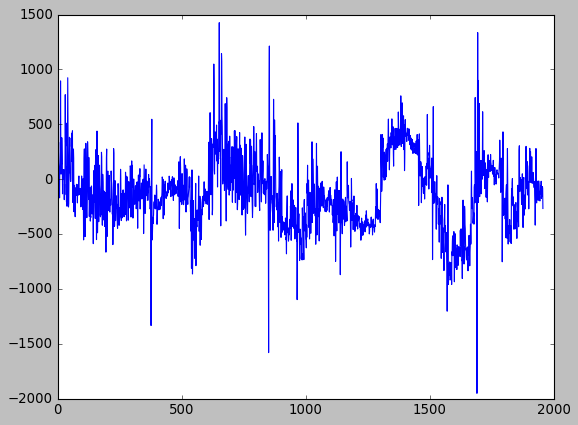

In [65]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_3 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_3= test_y.values
for i in range(len(inv_yhat_OHLCV_3)):
    inv_yhat_OHLCV_3[i] = inv_yhat_OHLCV_3[i] * scale + mean
    inv_y_OHLCV_3[i] = inv_y_OHLCV_3[i] * scale + mean

metrics(inv_y_OHLCV_3, inv_yhat_OHLCV_3)

In [66]:
Evaluate_candles(0, inv_y_OHLCV_3, inv_yhat_OHLCV_3)

5 свечей

Epoch 1/20
88/88 [==============================] - 18s 89ms/step - loss: 0.0786 - mean_absolute_error: 0.1535 - val_loss: 0.0365 - val_mean_absolute_error: 0.1814
Epoch 2/20
88/88 [==============================] - 6s 73ms/step - loss: 0.0162 - mean_absolute_error: 0.0839 - val_loss: 0.0321 - val_mean_absolute_error: 0.1559
Epoch 3/20
88/88 [==============================] - 6s 72ms/step - loss: 0.0131 - mean_absolute_error: 0.0771 - val_loss: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 4/20
88/88 [==============================] - 6s 73ms/step - loss: 0.0105 - mean_absolute_error: 0.0684 - val_loss: 0.0022 - val_mean_absolute_error: 0.0399
Epoch 5/20
88/88 [==============================] - 6s 72ms/step - loss: 0.0090 - mean_absolute_error: 0.0648 - val_loss: 0.0016 - val_mean_absolute_error: 0.0348
Epoch 6/20
62/62 [==============================] - 2s 17ms/step
Тест на стационарность:
	T-статистика = -3.004
	P-значение = 0.035
Критические значения :
	1%: -3.433728732020579 - Дан

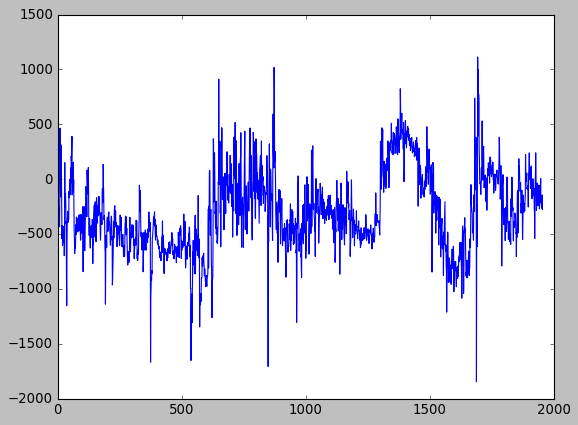

In [67]:
best_models_candle_5 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 5
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_5 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_5= test_y.values
for i in range(len(inv_yhat_OHLCV_5)):
    inv_yhat_OHLCV_5[i] = inv_yhat_OHLCV_5[i] * scale + mean
    inv_y_OHLCV_5[i] = inv_y_OHLCV_5[i] * scale + mean

metrics(inv_y_OHLCV_5, inv_yhat_OHLCV_5)

In [68]:
Evaluate_candles(1, inv_y_OHLCV_5, inv_yhat_OHLCV_5)

10 свечей

Epoch 1/20
88/88 [==============================] - 17s 120ms/step - loss: 0.1911 - mean_absolute_error: 0.1844 - val_loss: 0.0303 - val_mean_absolute_error: 0.1417
Epoch 2/20
88/88 [==============================] - 10s 119ms/step - loss: 0.0258 - mean_absolute_error: 0.1058 - val_loss: 0.0040 - val_mean_absolute_error: 0.0574
Epoch 3/20
88/88 [==============================] - 11s 122ms/step - loss: 0.0155 - mean_absolute_error: 0.0844 - val_loss: 0.1268 - val_mean_absolute_error: 0.3275
Epoch 4/20
88/88 [==============================] - 11s 121ms/step - loss: 0.0129 - mean_absolute_error: 0.0740 - val_loss: 0.0215 - val_mean_absolute_error: 0.1346
Epoch 5/20
61/61 [==============================] - 3s 28ms/step
Тест на стационарность:
	T-статистика = -2.284
	P-значение = 0.177
Критические значения :
	1%: -3.433737483274571 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.8630363792517297 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.567566613130669 - Дан

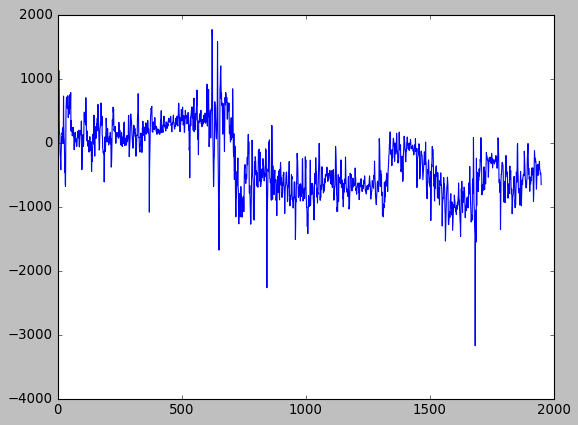

In [69]:
best_models_candle_10 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 10
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_10 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_10= test_y.values
for i in range(len(inv_yhat_OHLCV_10)):
    inv_yhat_OHLCV_10[i] = inv_yhat_OHLCV_10[i] * scale + mean
    inv_y_OHLCV_10[i] = inv_y_OHLCV_10[i] * scale + mean

metrics(inv_y_OHLCV_10, inv_yhat_OHLCV_10)

In [70]:
Evaluate_candles(2, inv_y_OHLCV_10, inv_yhat_OHLCV_10)

20 свечей

Epoch 1/20
87/87 [==============================] - 25s 188ms/step - loss: 0.4652 - mean_absolute_error: 0.1980 - val_loss: 0.0072 - val_mean_absolute_error: 0.0702
Epoch 2/20
87/87 [==============================] - 15s 173ms/step - loss: 0.0315 - mean_absolute_error: 0.1129 - val_loss: 0.0147 - val_mean_absolute_error: 0.1155
Epoch 3/20
87/87 [==============================] - 15s 175ms/step - loss: 0.0223 - mean_absolute_error: 0.1007 - val_loss: 0.0027 - val_mean_absolute_error: 0.0382
Epoch 4/20
87/87 [==============================] - 15s 174ms/step - loss: 0.0155 - mean_absolute_error: 0.0794 - val_loss: 6.7419e-04 - val_mean_absolute_error: 0.0210
Epoch 5/20
87/87 [==============================] - 15s 174ms/step - loss: 0.0131 - mean_absolute_error: 0.0762 - val_loss: 0.0013 - val_mean_absolute_error: 0.0264
Epoch 6/20
87/87 [==============================] - 15s 172ms/step - loss: 0.0098 - mean_absolute_error: 0.0633 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318
Epoch 

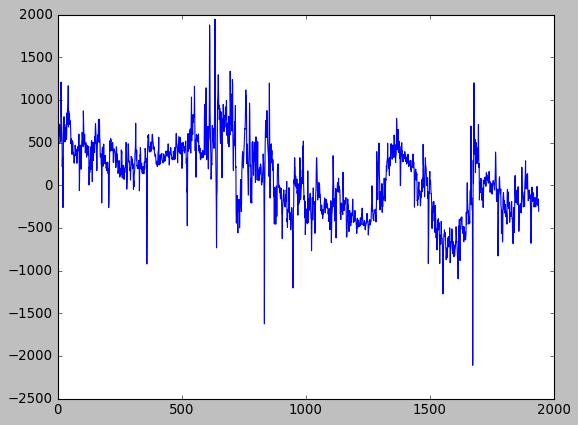

In [71]:
best_models_candle_20 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 20
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_20 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_20= test_y.values
for i in range(len(inv_yhat_OHLCV_20)):
    inv_yhat_OHLCV_20[i] = inv_yhat_OHLCV_20[i] * scale + mean
    inv_y_OHLCV_20[i] = inv_y_OHLCV_20[i] * scale + mean

metrics(inv_y_OHLCV_20, inv_yhat_OHLCV_20)

In [72]:
Evaluate_candles(3, inv_y_OHLCV_20, inv_yhat_OHLCV_20)

In [73]:
Table_of_Comapring_candles = For_Comparing_candles.copy()
Table_of_Comapring_candles.index = ['3','5','10', '20']
Table_of_Comapring_candles

,R2,SMAPE,SE,Среднее угадывание направления,Прибыль
3,0.985543,0.100090,336.4097,0.498212,1858.21
5,0.972560,0.123214,463.1026,0.518670,15436.76
10,0.956801,0.133325,580.2549,0.508718,-3568.59
20,0.976249,0.117984,430.0133,0.507732,-3570.79


Лучшим оказались последовательности длиной 5

# * Cross Validation for time-series

![Cross-Validation.png](attachment:Cross-Validation.png)

In [115]:
def split_and_normalization_cross(dataset, split_train_test):
    split = 0.8
    train = dataset[:split_train_test]
    test = dataset[split_train_test:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.columns.values

    train_norm = train.values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)
    
    # test

    test_norm = test.values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    
    
    # val
    val_norm = val.values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)



    train_X = train_norm.drop(['close_next'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_norm['close_next']
    
    test_X = test_norm.drop(['close_next'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_norm['close_next']


    val_X = val_norm.drop(['close_next'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_norm['close_next']

    return train_X, train_y, test_X, test_y, val_X, val_y

In [116]:
cross = {}
cross_split = int(len(df)/100)

for j in range(3,100):
    scaler = StandardScaler()

    train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization_cross(df[:(j+1)*cross_split], j*cross_split)
    
    print(train_X.shape[0]+val_X.shape[0], test_X.shape[0])
    
    n_steps = 10
    train_X = split_sequences(train_X, n_steps)
    test_X = split_sequences(test_X, n_steps)
    val_X = split_sequences(val_X, n_steps)


    train_y = train_y[n_steps - 1: -1]
    val_y = val_y[n_steps - 1: -1]
    test_y = test_y[n_steps - 1: -1]


    model = Sequential()
    model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
    model.add(LSTM(128, activation = 'relu',return_sequences=True))
    model.add(LSTM(56, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
    # fit network

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
    model.fit(train_X, train_y, batch_size=int(len(train_X)/100), epochs=20, validation_data=(val_X, val_y), callbacks = [callback])


    yhat = best_model_.predict(test_X)

    mean = scaler.mean_
    mean = mean[len(mean) - 1]
    scale = scaler.scale_
    scale = scale[len(scale) - 1]
    inv_yhat_OHLCV_10_cross = yhat.reshape(yhat.shape[0])
    inv_y_OHLCV_10_cross = test_y.copy().values
    for i in range(len(inv_yhat_OHLCV_10_cross)):
        inv_yhat_OHLCV_10_cross[i] = inv_yhat_OHLCV_10_cross[i] * scale + mean
        inv_y_OHLCV_10_cross[i] = inv_y_OHLCV_10_cross[i] * scale + mean

    cross[j] = (inv_y_OHLCV_10_cross, inv_yhat_OHLCV_10_cross)

1194 398
Epoch 1/20
105/105 [==============================] - 17s 56ms/step - loss: 0.2728 - mean_absolute_error: 0.2542 - val_loss: 19.4183 - val_mean_absolute_error: 4.0107
Epoch 2/20
105/105 [==============================] - 5s 49ms/step - loss: 0.1559 - mean_absolute_error: 0.1877 - val_loss: 24.9703 - val_mean_absolute_error: 4.3005
Epoch 3/20
105/105 [==============================] - 5s 49ms/step - loss: 0.1026 - mean_absolute_error: 0.1554 - val_loss: 28.5027 - val_mean_absolute_error: 4.7492
Epoch 4/20
105/105 [==============================] - 5s 51ms/step - loss: 0.0841 - mean_absolute_error: 0.1448 - val_loss: 9.0961 - val_mean_absolute_error: 2.5794
Epoch 5/20
105/105 [==============================] - 5s 50ms/step - loss: 0.0695 - mean_absolute_error: 0.1357 - val_loss: 17.3969 - val_mean_absolute_error: 3.7362
Epoch 6/20
105/105 [==============================] - 5s 50ms/step - loss: 0.0593 - mean_absolute_error: 0.1266 - val_loss: 16.8597 - val_mean_absolute_error: 3.

101/101 [==============================] - 13s 83ms/step - loss: 0.1005 - mean_absolute_error: 0.1916 - val_loss: 0.0320 - val_mean_absolute_error: 0.1688
Epoch 2/20
101/101 [==============================] - 6s 64ms/step - loss: 0.0246 - mean_absolute_error: 0.1185 - val_loss: 0.0058 - val_mean_absolute_error: 0.0701
Epoch 3/20
101/101 [==============================] - 6s 62ms/step - loss: 0.0153 - mean_absolute_error: 0.0943 - val_loss: 0.0163 - val_mean_absolute_error: 0.1224
Epoch 4/20
101/101 [==============================] - 6s 62ms/step - loss: 0.0129 - mean_absolute_error: 0.0888 - val_loss: 0.0024 - val_mean_absolute_error: 0.0442
Epoch 5/20
101/101 [==============================] - 6s 63ms/step - loss: 0.0101 - mean_absolute_error: 0.0763 - val_loss: 0.0173 - val_mean_absolute_error: 0.1287
Epoch 6/20
101/101 [==============================] - 6s 62ms/step - loss: 0.0101 - mean_absolute_error: 0.0781 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284
Epoch 7/20
101/101 [

Epoch 7/20
13/13 [==============================] - 1s 79ms/step
4776 398
Epoch 1/20
101/101 [==============================] - 15s 103ms/step - loss: 0.0981 - mean_absolute_error: 0.1758 - val_loss: 0.0381 - val_mean_absolute_error: 0.1610
Epoch 2/20
101/101 [==============================] - 10s 97ms/step - loss: 0.0224 - mean_absolute_error: 0.1048 - val_loss: 0.0077 - val_mean_absolute_error: 0.0636
Epoch 3/20
101/101 [==============================] - 10s 96ms/step - loss: 0.0137 - mean_absolute_error: 0.0876 - val_loss: 0.0522 - val_mean_absolute_error: 0.1616
Epoch 4/20
101/101 [==============================] - 10s 98ms/step - loss: 0.0115 - mean_absolute_error: 0.0793 - val_loss: 0.0297 - val_mean_absolute_error: 0.0923
Epoch 5/20
13/13 [==============================] - 1s 73ms/step
5174 398
Epoch 1/20
101/101 [==============================] - 17s 110ms/step - loss: 0.6119 - mean_absolute_error: 0.1892 - val_loss: 0.4024 - val_mean_absolute_error: 0.5818
Epoch 2/20
101/101 [

101/101 [==============================] - 15s 146ms/step - loss: 0.0092 - mean_absolute_error: 0.0687 - val_loss: 0.0608 - val_mean_absolute_error: 0.2305
Epoch 7/20
101/101 [==============================] - 15s 151ms/step - loss: 0.0083 - mean_absolute_error: 0.0664 - val_loss: 0.0206 - val_mean_absolute_error: 0.1330
Epoch 8/20
101/101 [==============================] - 15s 145ms/step - loss: 0.0075 - mean_absolute_error: 0.0616 - val_loss: 0.0019 - val_mean_absolute_error: 0.0272
Epoch 9/20
101/101 [==============================] - 15s 148ms/step - loss: 0.0065 - mean_absolute_error: 0.0567 - val_loss: 0.0103 - val_mean_absolute_error: 0.0895
Epoch 10/20
101/101 [==============================] - 15s 145ms/step - loss: 0.0062 - mean_absolute_error: 0.0567 - val_loss: 0.0020 - val_mean_absolute_error: 0.0276
Epoch 11/20
13/13 [==============================] - 1s 78ms/step
9950 398
Epoch 1/20
101/101 [==============================] - 19s 147ms/step - loss: 0.0949 - mean_absolute_

Epoch 4/20
101/101 [==============================] - 16s 155ms/step - loss: 0.0126 - mean_absolute_error: 0.0858 - val_loss: 0.0041 - val_mean_absolute_error: 0.0473
Epoch 5/20
13/13 [==============================] - 1s 78ms/step
12338 398
Epoch 1/20
101/101 [==============================] - 22s 166ms/step - loss: 0.1744 - mean_absolute_error: 0.1835 - val_loss: 0.0292 - val_mean_absolute_error: 0.1386
Epoch 2/20
101/101 [==============================] - 16s 160ms/step - loss: 0.0233 - mean_absolute_error: 0.1156 - val_loss: 0.0047 - val_mean_absolute_error: 0.0586
Epoch 3/20
101/101 [==============================] - 16s 159ms/step - loss: 0.0159 - mean_absolute_error: 0.0965 - val_loss: 0.0065 - val_mean_absolute_error: 0.0664
Epoch 4/20
101/101 [==============================] - 16s 155ms/step - loss: 0.0122 - mean_absolute_error: 0.0854 - val_loss: 0.0028 - val_mean_absolute_error: 0.0441
Epoch 5/20
101/101 [==============================] - 16s 157ms/step - loss: 0.0104 - mean

Epoch 2/20
101/101 [==============================] - 15s 148ms/step - loss: 0.0225 - mean_absolute_error: 0.1081 - val_loss: 0.0112 - val_mean_absolute_error: 0.0744
Epoch 3/20
101/101 [==============================] - 15s 149ms/step - loss: 0.0140 - mean_absolute_error: 0.0890 - val_loss: 0.0112 - val_mean_absolute_error: 0.0693
Epoch 4/20
101/101 [==============================] - 15s 149ms/step - loss: 0.0113 - mean_absolute_error: 0.0770 - val_loss: 0.0090 - val_mean_absolute_error: 0.0669
Epoch 5/20
101/101 [==============================] - 15s 149ms/step - loss: 0.0093 - mean_absolute_error: 0.0688 - val_loss: 0.0065 - val_mean_absolute_error: 0.0591
Epoch 6/20
101/101 [==============================] - 15s 149ms/step - loss: 0.0086 - mean_absolute_error: 0.0664 - val_loss: 0.0129 - val_mean_absolute_error: 0.0942
Epoch 7/20
101/101 [==============================] - 15s 149ms/step - loss: 0.0076 - mean_absolute_error: 0.0658 - val_loss: 0.0070 - val_mean_absolute_error: 0.049

101/101 [==============================] - 22s 214ms/step - loss: 0.0250 - mean_absolute_error: 0.1153 - val_loss: 0.1961 - val_mean_absolute_error: 0.2339
Epoch 3/20
101/101 [==============================] - 22s 214ms/step - loss: 0.0168 - mean_absolute_error: 0.0974 - val_loss: 0.1007 - val_mean_absolute_error: 0.1842
Epoch 4/20
101/101 [==============================] - 21s 213ms/step - loss: 0.0130 - mean_absolute_error: 0.0850 - val_loss: 0.0539 - val_mean_absolute_error: 0.1422
Epoch 5/20
101/101 [==============================] - 22s 213ms/step - loss: 0.0105 - mean_absolute_error: 0.0770 - val_loss: 0.0160 - val_mean_absolute_error: 0.1000
Epoch 6/20
101/101 [==============================] - 21s 213ms/step - loss: 0.0096 - mean_absolute_error: 0.0735 - val_loss: 0.0607 - val_mean_absolute_error: 0.1744
Epoch 7/20
101/101 [==============================] - 22s 215ms/step - loss: 0.0083 - mean_absolute_error: 0.0668 - val_loss: 0.0237 - val_mean_absolute_error: 0.0624
Epoch 8/2

101/101 [==============================] - 29s 287ms/step - loss: 0.0135 - mean_absolute_error: 0.0834 - val_loss: 138.1181 - val_mean_absolute_error: 7.8402
Epoch 5/20
101/101 [==============================] - 27s 271ms/step - loss: 0.0110 - mean_absolute_error: 0.0790 - val_loss: 427.2633 - val_mean_absolute_error: 14.5544
Epoch 6/20
101/101 [==============================] - 27s 266ms/step - loss: 0.0095 - mean_absolute_error: 0.0712 - val_loss: 48.2740 - val_mean_absolute_error: 4.3929
Epoch 7/20
101/101 [==============================] - 25s 248ms/step - loss: 0.0084 - mean_absolute_error: 0.0655 - val_loss: 19.3249 - val_mean_absolute_error: 3.9646
Epoch 8/20
101/101 [==============================] - 26s 255ms/step - loss: 0.0075 - mean_absolute_error: 0.0634 - val_loss: 7.6588 - val_mean_absolute_error: 2.3558
Epoch 9/20
101/101 [==============================] - 26s 254ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 8.0830 - val_mean_absolute_error: 2.3710
Ep

Epoch 2/20
101/101 [==============================] - 27s 269ms/step - loss: 0.0152 - mean_absolute_error: 0.0734 - val_loss: 0.0150 - val_mean_absolute_error: 0.0962
Epoch 3/20
101/101 [==============================] - 27s 272ms/step - loss: 0.0120 - mean_absolute_error: 0.0653 - val_loss: 0.0554 - val_mean_absolute_error: 0.2043
Epoch 4/20
101/101 [==============================] - 28s 275ms/step - loss: 0.0104 - mean_absolute_error: 0.0627 - val_loss: 0.0788 - val_mean_absolute_error: 0.2551
Epoch 5/20
101/101 [==============================] - 28s 278ms/step - loss: 0.0076 - mean_absolute_error: 0.0533 - val_loss: 0.0113 - val_mean_absolute_error: 0.0825
Epoch 6/20
101/101 [==============================] - 28s 278ms/step - loss: 0.0072 - mean_absolute_error: 0.0534 - val_loss: 0.0261 - val_mean_absolute_error: 0.1408
Epoch 7/20
101/101 [==============================] - 28s 282ms/step - loss: 0.0065 - mean_absolute_error: 0.0498 - val_loss: 0.0144 - val_mean_absolute_error: 0.085

Epoch 8/20
101/101 [==============================] - 26s 260ms/step - loss: 0.0061 - mean_absolute_error: 0.0526 - val_loss: 0.0144 - val_mean_absolute_error: 0.0890
Epoch 9/20
101/101 [==============================] - 26s 260ms/step - loss: 0.0054 - mean_absolute_error: 0.0502 - val_loss: 0.0089 - val_mean_absolute_error: 0.0789
Epoch 10/20
101/101 [==============================] - 26s 259ms/step - loss: 0.0053 - mean_absolute_error: 0.0487 - val_loss: 0.0314 - val_mean_absolute_error: 0.1416
Epoch 11/20
101/101 [==============================] - 26s 260ms/step - loss: 0.0046 - mean_absolute_error: 0.0439 - val_loss: 0.0368 - val_mean_absolute_error: 0.1622
Epoch 12/20
13/13 [==============================] - 1s 80ms/step
31044 398
Epoch 1/20
101/101 [==============================] - 34s 286ms/step - loss: 1.2717 - mean_absolute_error: 0.1818 - val_loss: 0.2397 - val_mean_absolute_error: 0.4257
Epoch 2/20
101/101 [==============================] - 28s 278ms/step - loss: 0.0263 - m

Epoch 4/20
101/101 [==============================] - 32s 317ms/step - loss: 0.0098 - mean_absolute_error: 0.0799 - val_loss: 0.0013 - val_mean_absolute_error: 0.0272
Epoch 5/20
101/101 [==============================] - 31s 303ms/step - loss: 0.0080 - mean_absolute_error: 0.0690 - val_loss: 0.0209 - val_mean_absolute_error: 0.1045
Epoch 6/20
101/101 [==============================] - 31s 305ms/step - loss: 0.0068 - mean_absolute_error: 0.0632 - val_loss: 0.0075 - val_mean_absolute_error: 0.0669
Epoch 7/20
13/13 [==============================] - 1s 78ms/step
36218 398
Epoch 1/20
101/101 [==============================] - 36s 309ms/step - loss: 0.1096 - mean_absolute_error: 0.1641 - val_loss: 0.0225 - val_mean_absolute_error: 0.1222
Epoch 2/20
101/101 [==============================] - 31s 307ms/step - loss: 0.0186 - mean_absolute_error: 0.1061 - val_loss: 0.0044 - val_mean_absolute_error: 0.0578
Epoch 3/20
101/101 [==============================] - 31s 310ms/step - loss: 0.0127 - mean

Epoch 2/20
101/101 [==============================] - 33s 328ms/step - loss: 0.0172 - mean_absolute_error: 0.1019 - val_loss: 0.0152 - val_mean_absolute_error: 0.1108
Epoch 3/20
101/101 [==============================] - 33s 329ms/step - loss: 0.0123 - mean_absolute_error: 0.0905 - val_loss: 0.0036 - val_mean_absolute_error: 0.0433
Epoch 4/20
101/101 [==============================] - 33s 328ms/step - loss: 0.0096 - mean_absolute_error: 0.0797 - val_loss: 0.0054 - val_mean_absolute_error: 0.0603
Epoch 5/20
101/101 [==============================] - 33s 329ms/step - loss: 0.0083 - mean_absolute_error: 0.0747 - val_loss: 0.0021 - val_mean_absolute_error: 0.0399
Epoch 6/20
101/101 [==============================] - 33s 327ms/step - loss: 0.0071 - mean_absolute_error: 0.0686 - val_loss: 0.0020 - val_mean_absolute_error: 0.0366
Epoch 7/20
101/101 [==============================] - 33s 328ms/step - loss: 0.0063 - mean_absolute_error: 0.0636 - val_loss: 0.0052 - val_mean_absolute_error: 0.058

In [117]:
predictions = []
true = []
for key, value in cross.items():
    predictions = predictions + list(value[1])
    true = true + list(value[0])

Тест на стационарность:
	T-статистика = -1.790
	P-значение = 0.385
Критические значения :
	1%: -3.430524012737646 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.861616909496266 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.5668109364787193 - Данные не стационарны с вероятностью 90% процентов
MAD: 4514.7954
MSE: 123587257.5524
MAPE: 0.1139
MPE: 0.0874
Стандартная ошибка: 11116.9806
Среднее угадывание направления:  0.5121828085558655
R2: 0.5725756640598205
SMAPE: 0.3859420685575443
Прибыль, при условии закрытия сделки по каждой свечи: -42400.97000000057
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -319103.01779297023


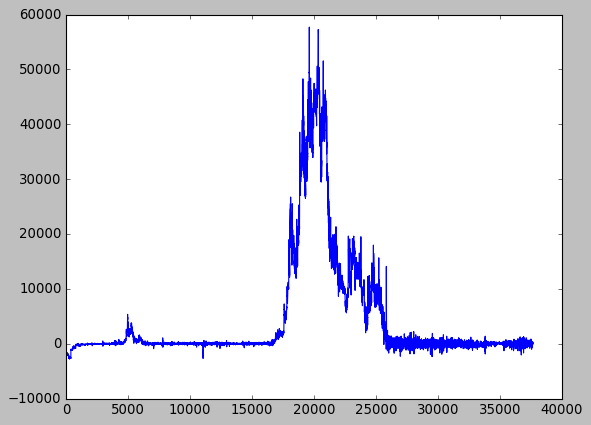

In [118]:
metrics(array(true), array(predictions))

In [119]:
metrics(cross[2][0], cross[2][1])

KeyError: 2

In [ ]:
metrics(cross[3][0], cross[3][1])

In [ ]:
metrics(cross[4][0], cross[4][1])

In [ ]:
metrics(cross[5][0], cross[5][1])

# NN selection

Выбор наилучшего архитектуры

In [74]:
For_Comparing_NN = pd.DataFrame(np.zeros([5,5]), columns=['R2','SMAPE','SE','Среднее угадывание направления','Прибыль'])

def Evaluate_NN(n, real,forecast):
   
    For_Comparing_NN.loc[n,'R2']  = round(r2_score(real,forecast),20)
    For_Comparing_NN.loc[n,'SMAPE']   = round(np.sqrt(smape(real, forecast)),20)
    For_Comparing_NN.loc[n,'SE'] = round(((real-forecast)**2).mean()**0.5,4)
    For_Comparing_NN.loc[n,'Среднее угадывание направления']  = round(direction(real, forecast),20)
    For_Comparing_NN.loc[n,'Прибыль']= round(count_money(real, forecast),20)


In [75]:
n_steps = 5

LSTM

Trial 5 Complete [00h 04m 15s]
val_mean_absolute_error: 0.010815202258527279

Best val_mean_absolute_error So Far: 0.010684946551918983
Total elapsed time: 00h 29m 04s
INFO:tensorflow:Oracle triggered exit
62/62 [==============================] - 4s 44ms/step
Тест на стационарность:
	T-статистика = -4.873
	P-значение = 0.000
Критические значения :
	1%: -3.433735729398985 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8630356049379273 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5675662008429145 - Данные  стационарны с вероятностью 90% процентов
MAD: 149.7028
MSE: 44855.4607
MAPE: 0.0057
MPE: -0.0025
Стандартная ошибка: 211.7911
Среднее угадывание направления:  0.5058823529411764
R2: 0.9942608695572257
SMAPE: 0.07519543653243185
Прибыль, при условии закрытия сделки по каждой свечи: -1467.2199999999975
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -33574.459296874964


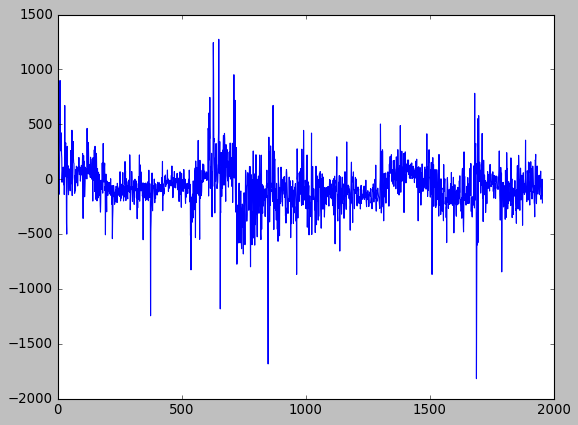

In [76]:
def build_model_LSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_LSTM = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=16, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_LSTM.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_LSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_LSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_LSTM)):
    inv_yhat_OHLCV_LSTM[i] = inv_yhat_OHLCV_LSTM[i] * scale + mean
    inv_y_OHLCV_LSTM[i] = inv_y_OHLCV_LSTM[i] * scale + mean

metrics(inv_y_OHLCV_LSTM, inv_yhat_OHLCV_LSTM)

In [58]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 280)           319200    
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           209408    
                                                                 
 lstm_2 (LSTM)               (None, 72)                57888     
                                                                 
 dense (Dense)               (None, 1)                 73        
                                                                 
Total params: 586,569
Trainable params: 586,569
Non-trainable params: 0
_________________________________________________________________


In [59]:
Evaluate_NN(0, inv_y_OHLCV_LSTM, inv_yhat_OHLCV_LSTM)

GRU

Trial 5 Complete [00h 01m 24s]
val_mean_absolute_error: 0.02650928497314453

Best val_mean_absolute_error So Far: 0.009526398964226246
Total elapsed time: 00h 09m 47s
INFO:tensorflow:Oracle triggered exit
62/62 [==============================] - 3s 32ms/step
Тест на стационарность:
	T-статистика = -5.902
	P-значение = 0.000
Критические значения :
	1%: -3.4337304786522114 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8630332867971835 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5675649665362372 - Данные  стационарны с вероятностью 90% процентов
MAD: 134.2315
MSE: 37921.7381
MAPE: 0.0051
MPE: 0.0029
Стандартная ошибка: 194.735
Среднее угадывание направления:  0.4864450127877238
R2: 0.9951480199289154
SMAPE: 0.07140175171680631
Прибыль, при условии закрытия сделки по каждой свечи: -170.6999999999789
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -43406.5884374998


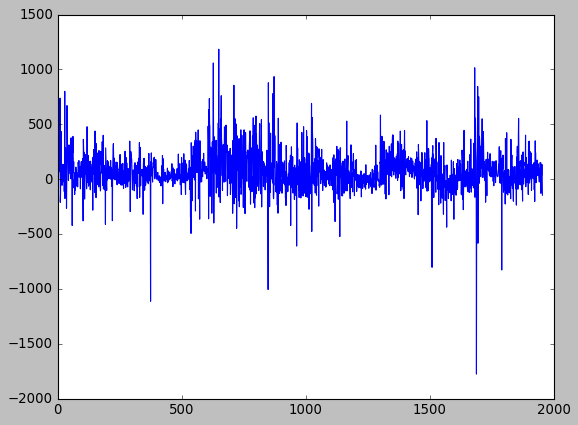

In [77]:
def build_model_GRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_GRU = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_GRU,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=16, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_GRU.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_GRU = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_GRU= test_y.values
for i in range(len(inv_yhat_OHLCV_GRU)):
    inv_yhat_OHLCV_GRU[i] = inv_yhat_OHLCV_GRU[i] * scale + mean
    inv_y_OHLCV_GRU[i] = inv_y_OHLCV_GRU[i] * scale + mean

metrics(inv_y_OHLCV_GRU, inv_yhat_OHLCV_GRU)

In [61]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 472)           676848    
                                                                 
 gru_1 (GRU)                 (None, 104)               180336    
                                                                 
 dense (Dense)               (None, 1)                 105       
                                                                 
Total params: 857,289
Trainable params: 857,289
Non-trainable params: 0
_________________________________________________________________


In [62]:
Evaluate_NN(1, inv_y_OHLCV_GRU, inv_yhat_OHLCV_GRU)

BiLSTM

Trial 1 Complete [01h 33m 00s]
val_mean_absolute_error: 0.023157421499490738

Best val_mean_absolute_error So Far: 0.023157421499490738
Total elapsed time: 01h 33m 00s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 51s 163ms/step
Тест на стационарность:
	T-статистика = -16.163
	P-значение = 0.000
Критические значения :
	1%: -3.4311752073718877 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.861904682069015 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5669641155996623 - Данные  стационарны с вероятностью 90% процентов
MAD: 223.8656
MSE: 88162.0704
MAPE: 0.0106
MPE: -0.003
Стандартная ошибка: 296.921
Среднее угадывание направления:  0.5102477052684522
R2: 0.9942468200771349
SMAPE: 0.1027903981255573
Прибыль, при условии закрытия сделки по каждой свечи: 10024.589999999935
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -74503.10855468787


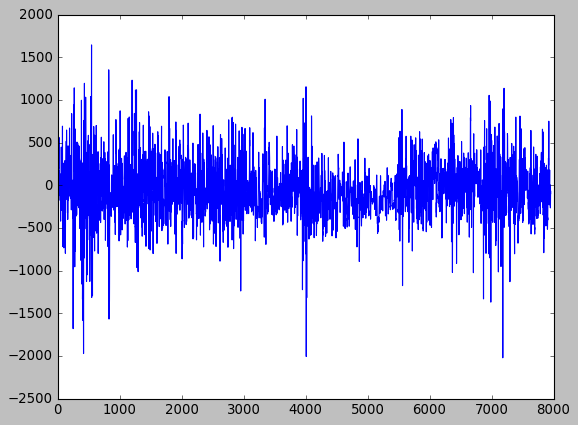

In [81]:
def build_model_BiLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_BiLSTM = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiLSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=1,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_BiLSTM.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_BiLSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_BiLSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_BiLSTM)):
    inv_yhat_OHLCV_BiLSTM[i] = inv_yhat_OHLCV_BiLSTM[i] * scale + mean
    inv_y_OHLCV_BiLSTM[i] = inv_y_OHLCV_BiLSTM[i] * scale + mean

metrics(inv_y_OHLCV_BiLSTM, inv_yhat_OHLCV_BiLSTM)

In [83]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 608)          751488    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 256)          754688    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 10, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 144)              189504    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 1

In [84]:
Evaluate_NN(2, inv_y_OHLCV_BiLSTM, inv_yhat_OHLCV_BiLSTM)

BiGRU

Trial 1 Complete [00h 29m 59s]
val_mean_absolute_error: 0.03344228118658066

Best val_mean_absolute_error So Far: 0.03344228118658066
Total elapsed time: 00h 29m 59s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 54s 182ms/step
Тест на стационарность:
	T-статистика = -8.741
	P-значение = 0.000
Критические значения :
	1%: -3.4311767723529276 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.861905373581411 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5669644836994863 - Данные  стационарны с вероятностью 90% процентов
MAD: 236.4513
MSE: 96772.3074
MAPE: 0.0106
MPE: -0.003
Стандартная ошибка: 311.0825
Среднее угадывание направления:  0.509505224726174
R2: 0.9936678385119732
SMAPE: 0.10291153583279208
Прибыль, при условии закрытия сделки по каждой свечи: -6591.660000000029
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -79525.79097656257


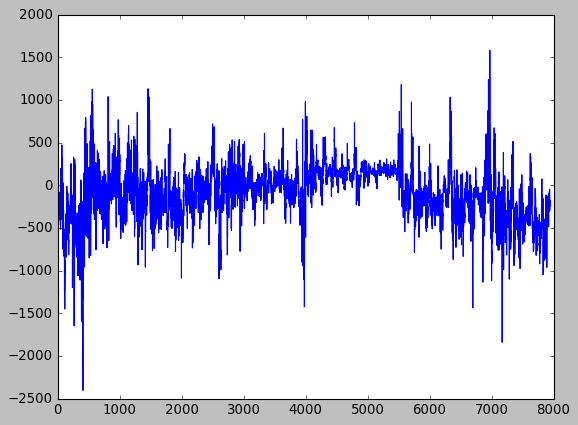

In [66]:
def build_model_BiGRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model


best_models_BiGRU = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiGRU,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=1,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_BiGRU.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_BiGRU = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_BiGRU= test_y.values
for i in range(len(inv_yhat_OHLCV_BiGRU)):
    inv_yhat_OHLCV_BiGRU[i] = inv_yhat_OHLCV_BiGRU[i] * scale + mean
    inv_y_OHLCV_BiGRU[i] = inv_y_OHLCV_BiGRU[i] * scale + mean

metrics(inv_y_OHLCV_BiGRU, inv_yhat_OHLCV_BiGRU)

In [67]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 928)          1308480   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          812544    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 144)              142560    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 145       
                                                                 
Total params: 2,263,729
Trainable params: 2,263,729
Non-trainable params: 0
______________________________________________

In [68]:
Evaluate_NN(3, inv_y_OHLCV_BiGRU, inv_yhat_OHLCV_BiGRU)

In [69]:
from tensorflow.keras.layers import ConvLSTM2D

Conv-LSTM

Trial 1 Complete [00h 14m 54s]
val_mean_absolute_error: 0.01853780634701252

Best val_mean_absolute_error So Far: 0.01853780634701252
Total elapsed time: 00h 14m 54s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 1s 4ms/step
Тест на стационарность:
	T-статистика = -9.009
	P-значение = 0.000
Критические значения :
	1%: -3.4311764588820295 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8619052350692114 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5669644099678797 - Данные  стационарны с вероятностью 90% процентов
MAD: 301.0038
MSE: 125677.6278
MAPE: 0.0138
MPE: -0.013
Стандартная ошибка: 354.5104
Среднее угадывание направления:  0.5022031977842125
R2: 0.991776459031815
SMAPE: 0.1170751970274159
Прибыль, при условии закрытия сделки по каждой свечи: -6544.599999999982
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -48676.866250000065


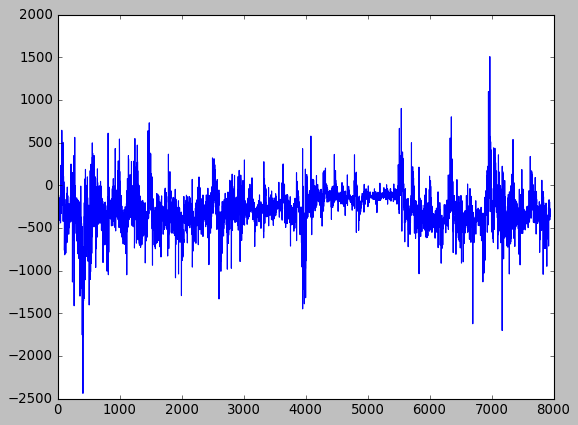

In [70]:
def build_model_ConvLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(ConvLSTM2D(input_shape=(1, 1, train_X.shape[3], train_X.shape[4]),
                            activation=activation_choice, filters=32, padding='same', kernel_size=(1,5)))
    
    model.add(Flatten())
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)

train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1],train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1],test_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], 1, 1, val_X.shape[1],val_X.shape[2]))

print(train_X.shape)

train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]

from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_ConvLSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=1,
                      #seed=123,
                      project_name="BTC1HCONVLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_ConvLSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_ConvLSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_ConvLSTM)):
    inv_yhat_OHLCV_ConvLSTM[i] = inv_yhat_OHLCV_ConvLSTM[i] * scale + mean
    inv_y_OHLCV_ConvLSTM[i] = inv_y_OHLCV_ConvLSTM[i] * scale + mean

metrics(inv_y_OHLCV_ConvLSTM, inv_yhat_OHLCV_ConvLSTM)

In [71]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 20, 32)         23168     
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 23,809
Trainable params: 23,809
Non-trainable params: 0
_________________________________________________________________


In [72]:
Evaluate_NN(4, inv_y_OHLCV_ConvLSTM, inv_yhat_OHLCV_ConvLSTM)

In [85]:
Table_of_Comapring_NN = For_Comparing_NN.copy()
Table_of_Comapring_NN.index = ['LSTM','GRU','BiLSTM','BiGRU','CONV-LSTM']
Table_of_Comapring_NN

,R2,SMAPE,SE,Среднее угадывание направления,Прибыль
LSTM,0.991577,0.113571,358.7766,0.519451,-3153.70
GRU,0.992745,0.110073,332.9872,0.499937,-1693.60
BiLSTM,0.994247,0.102790,296.9210,0.510248,10024.59
BiGRU,0.993668,0.102912,311.0825,0.509505,-6591.66
CONV-LSTM,0.991776,0.117075,354.5104,0.502203,-6544.60


Trial 1 Complete [00h 11m 19s]
val_mean_absolute_error: 0.040445536375045776

Best val_mean_absolute_error So Far: 0.040445536375045776
Total elapsed time: 00h 11m 19s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 10s 12ms/step
Тест на стационарность:
	T-статистика = -7.733
	P-значение = 0.000
Критические значения :
	1%: -3.4311759369584323 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.861905004448774 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5669642872060248 - Данные  стационарны с вероятностью 90% процентов
MAD: 756.3972
MSE: 733812.9567
MAPE: 0.0374
MPE: -0.0337
Стандартная ошибка: 856.6288
Среднее угадывание направления:  0.5106249214133032
R2: 0.9521136703090736
SMAPE: 0.19107768560190758
Прибыль, при условии закрытия сделки по каждой свечи: 10547.07000000005
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -15042.37300781245


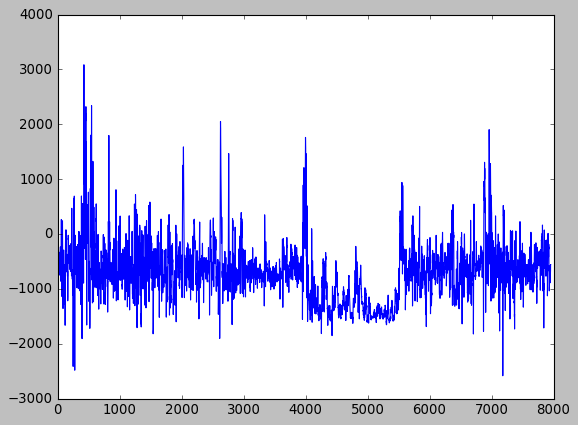

In [74]:
best_models_ConvLSTM = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 10
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)

train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1],train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1],test_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], 1, 1, val_X.shape[1],val_X.shape[2]))

print(train_X.shape)

train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]



def build_model_ConvLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(ConvLSTM2D(input_shape=(1, 1, train_X.shape[3], train_X.shape[4]),
                            activation=activation_choice, filters=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=8,    # минимальное количество нейронов - 128
                                   max_value=64,   # максимальное количество - 1024
                                   step=8),padding='same', kernel_size=(1,5), return_sequences=True))
    
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(ConvLSTM2D(
                            activation=activation_choice, filters=hyperparams.Int('units_hidden',    # Полносвязный слой с разным количеством нейронов
                                   min_value=8,    # минимальное количество нейронов - 128
                                   max_value=64,   # максимальное количество - 1024
                                   step=8),padding='same', kernel_size=(1,5), return_sequences=True))
    
    
    model.add(ConvLSTM2D(
                            activation=activation_choice, filters=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=8,    # минимальное количество нейронов - 128
                                   max_value=64,   # максимальное количество - 1024
                                   step=8),padding='same', kernel_size=(1,5)))
    model.add(Flatten())
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_ConvLSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=1,
                      #seed=123,
                      project_name="BTCCONVLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]


yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_ConvLSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_ConvLSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_ConvLSTM)):
    inv_yhat_OHLCV_ConvLSTM[i] = inv_yhat_OHLCV_ConvLSTM[i] * scale + mean
    inv_y_OHLCV_ConvLSTM[i] = inv_y_OHLCV_ConvLSTM[i] * scale + mean

metrics(inv_y_OHLCV_ConvLSTM, inv_yhat_OHLCV_ConvLSTM)

Лучше всего себя показали BiLSTM сеть